In [164]:
# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np
from scipy.stats import skew
import scipy.stats as st
import sidetable
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
import pingouin as pg

# librerías para la visualización de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tamaño fijo de gráficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)

# Configuración warnings
# ======================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pingouin

# Objectives
Description of data, identification of variables to be taken into account for the calculation of health insurance premiums.



---

In [86]:
df = pd.read_csv("../data/00-insurance.csv", index_col = 0).reset_index()
df.head(2)

age     sex    bmi  children smoker     region     charges
0   19  female  27.90         0    yes  southwest  16884.9240
1   18    male  33.77         1     no  southeast   1725.5523

## Understand the variables we have and what our dataframe looks like.

In [9]:
# number of rows and columns in the dataframe

df.shape

(1338, 7)

In [10]:
# general data frame information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [11]:
# name of the columns of our dataframe

df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

### Statistics

In [12]:
# leading statistics of the numeric columns.

df.describe().T

count          mean           std        min         25%       50%  \
age       1338.0     39.207025     14.049960    18.0000    27.00000    39.000   
bmi       1338.0     30.663397      6.098187    15.9600    26.29625    30.400   
children  1338.0      1.094918      1.205493     0.0000     0.00000     1.000   
charges   1338.0  13270.422265  12110.011237  1121.8739  4740.28715  9382.033   

                   75%          max  
age          51.000000     64.00000  
bmi          34.693750     53.13000  
children      2.000000      5.00000  
charges   16639.912515  63770.42801

In [13]:
# main statistics of the categorical variables

df.describe(include ="object").T

count unique        top  freq
sex     1338      2       male   676
smoker  1338      2         no  1064
region  1338      4  southeast   364

Data integrity:
- Smoking habits, majority non-smokers (274 smokers)
- BMI mean 30, overweight (more than 75% over BMI 25)

---

## Null

In [14]:
df.isnull().sum()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

---

## Duplicates

In [15]:
# duplicados 

df.duplicated().sum()

1

In [16]:
df[df.duplicated()== True] 

age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df.duplicated().sum()

0

---

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


---

# Outliers

In [20]:
numericas = df.select_dtypes(include=['int64', 'float64'])
numericas.head(2)

age    bmi  children     charges
0   19  27.90         0  16884.9240
1   18  33.77         1   1725.5523

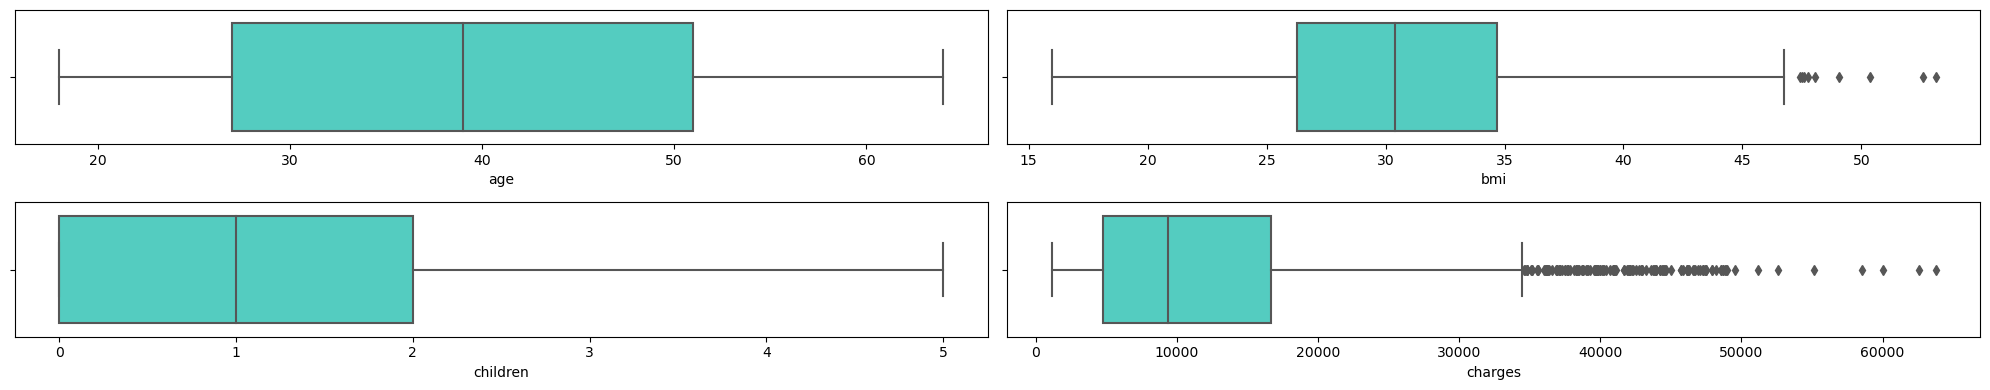

In [77]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "turquoise") 
plt.tight_layout()
plt.show();

In the boxplots we see a lot of outliers, we see the distributions to decide the treatment, I am not going to do anything with them yet, before I see if I unfold the dataset or not.

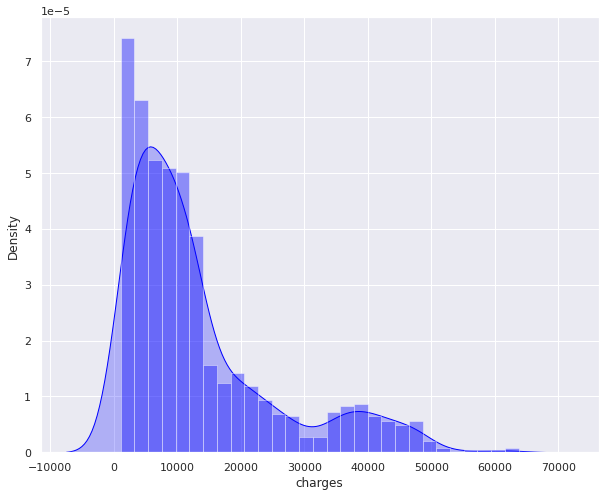

In [108]:
# I'm going to look at the distribution of variable charges
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df["charges"], 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});


## We analyse the numerical variables of the dataset

### Distributions

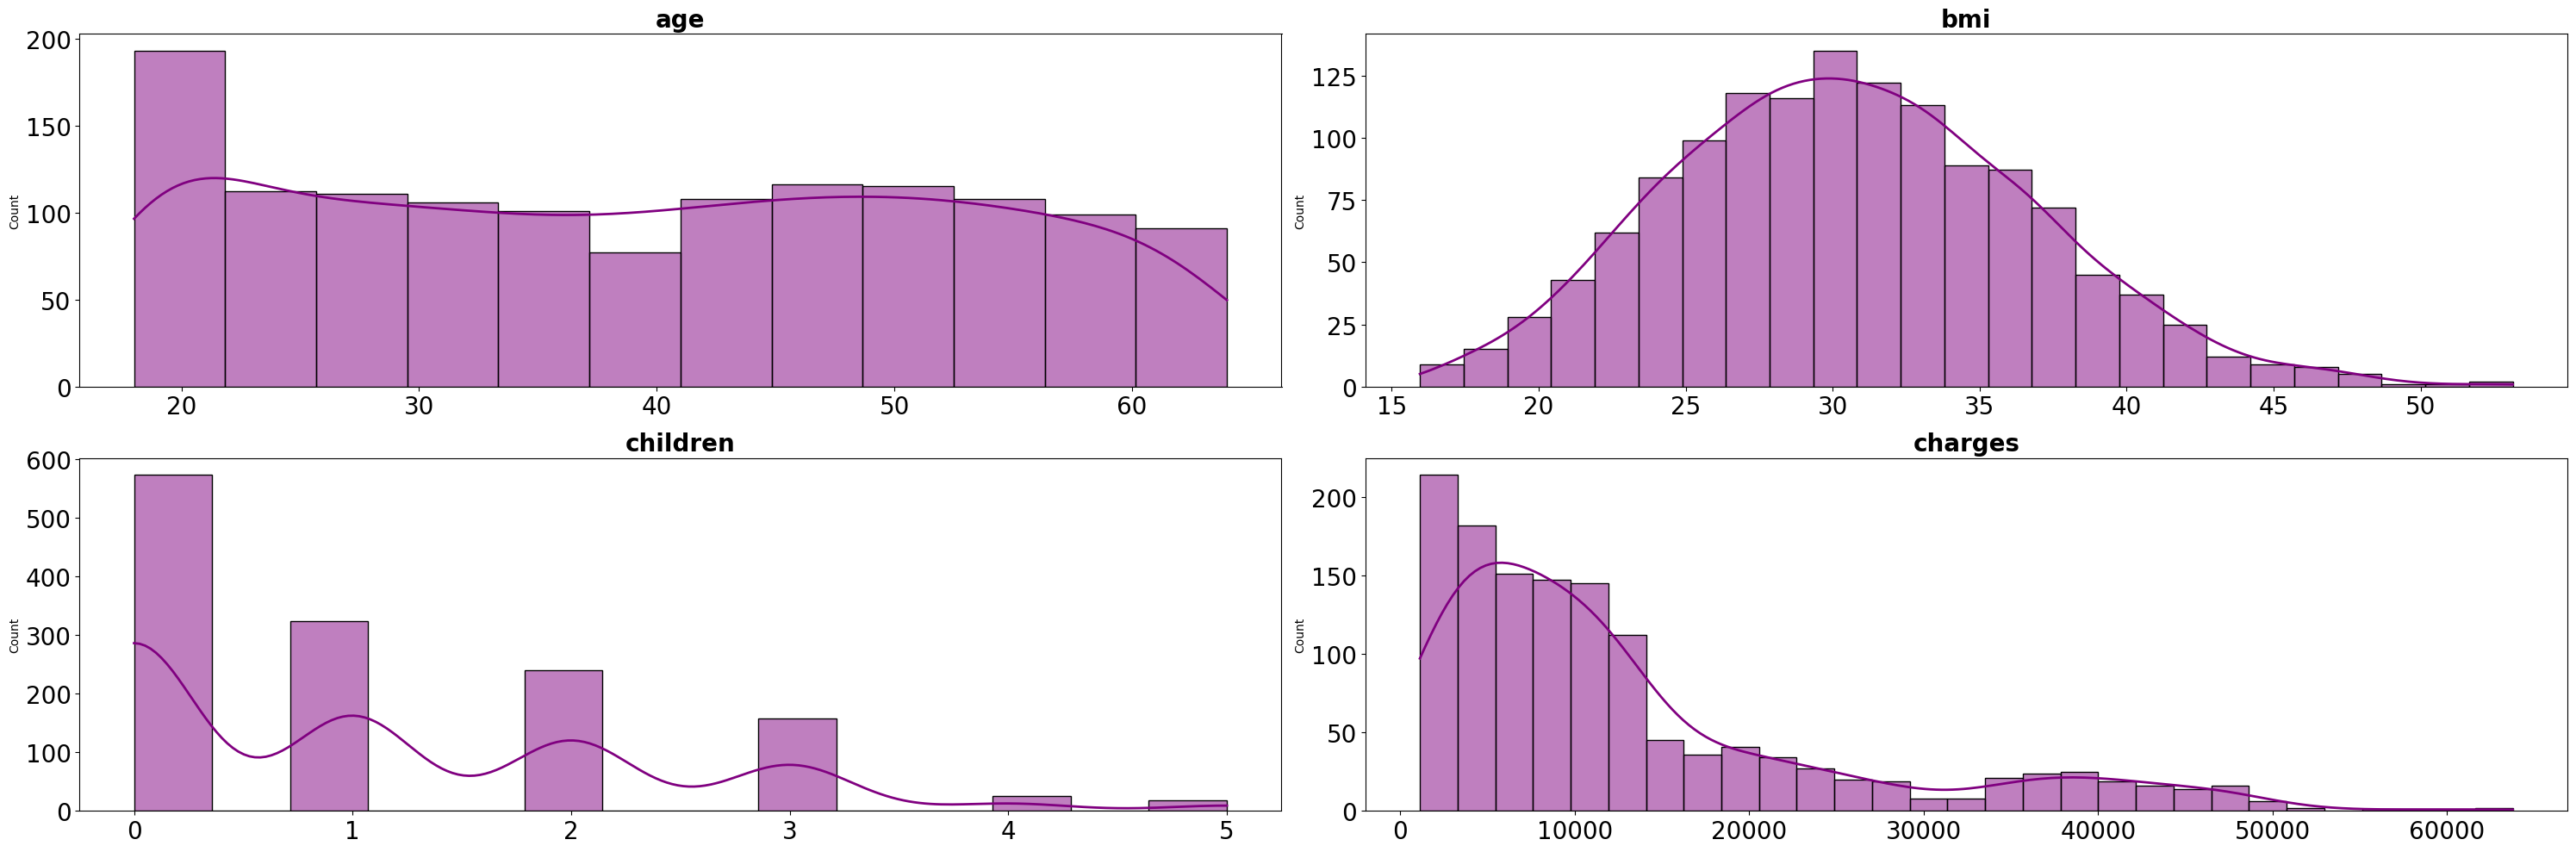

In [78]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterator
for i, colum in enumerate(numericas.columns): 
    sns.histplot(
        data = numericas[colum],
        kde = True,
        color = "purple", 
        line_kws = {"linewidth": 2}, 
        alpha = 0.5, 
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

### Relación con la variable respuesta

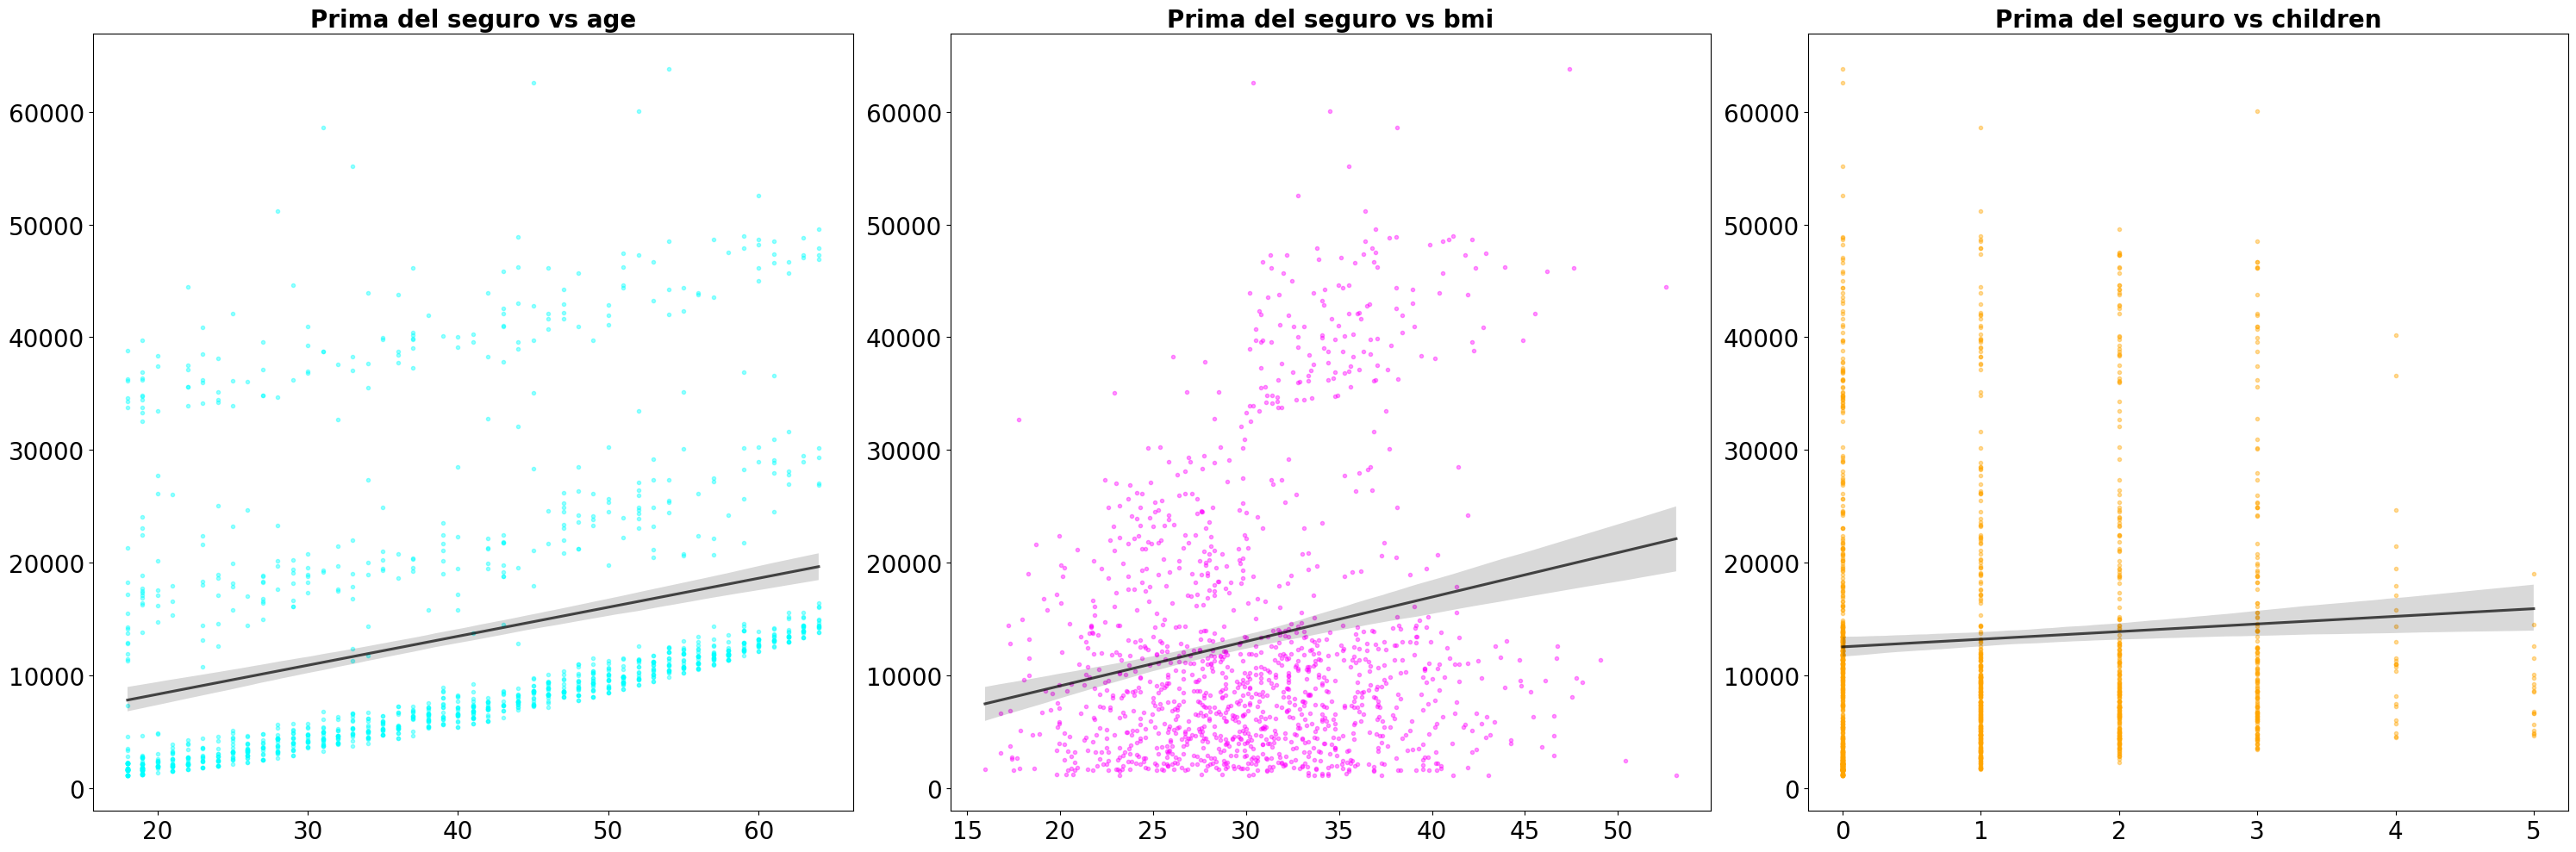

In [55]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
lista_colores = ["cyan", "magenta", "orange"]

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["charges"], 
        color = lista_colores[i], 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Prima del seguro vs {colum}", fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();


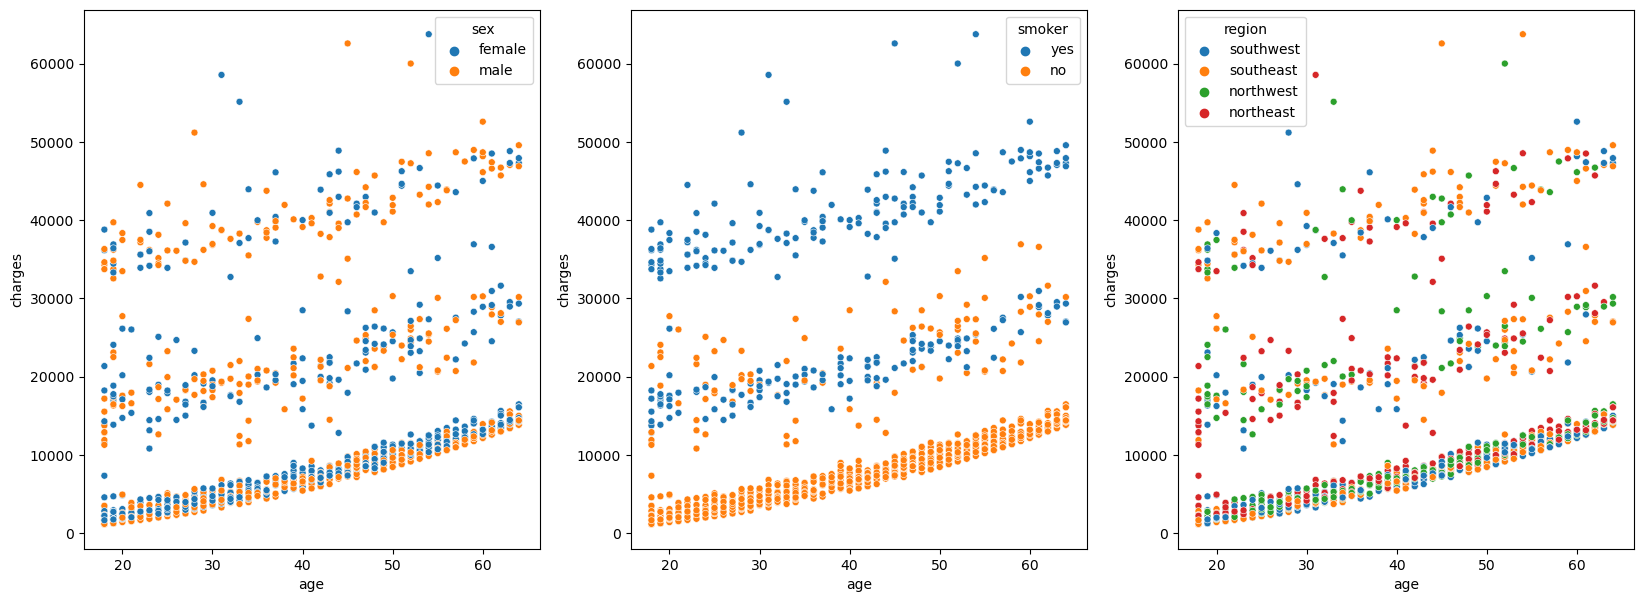

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='age', y='charges', data = df,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

Here we see that in age, there are about three clear trend lines in the distribution of our data.  
**-------------------------------------All 3 increase with age and tobacco-------------------------------------**

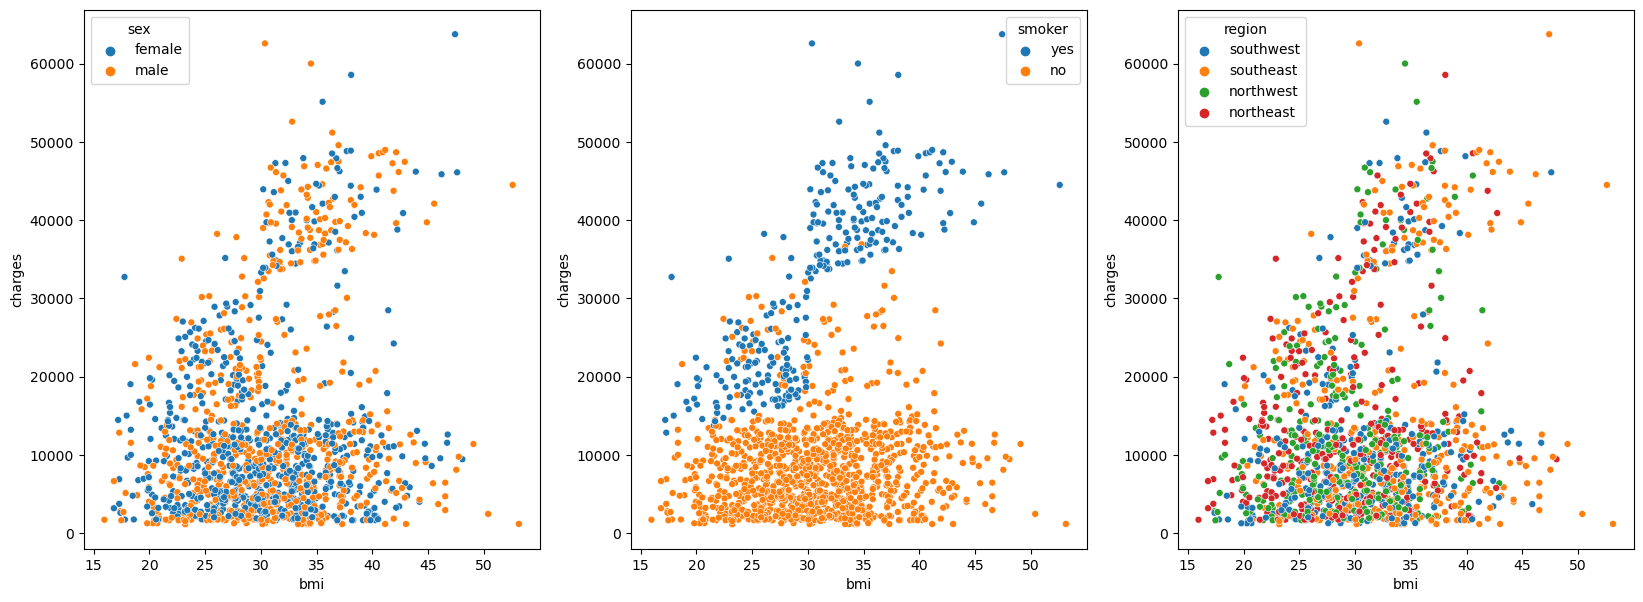

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))

for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='bmi', y='charges', data = df,
                    s = 25,    
                    hue = categoricas.columns[i], 
                    ax=axes[i])  
plt.show(); 

**-------------------------------We see that there is a clear increase  in charges with tobacco--------------------------**

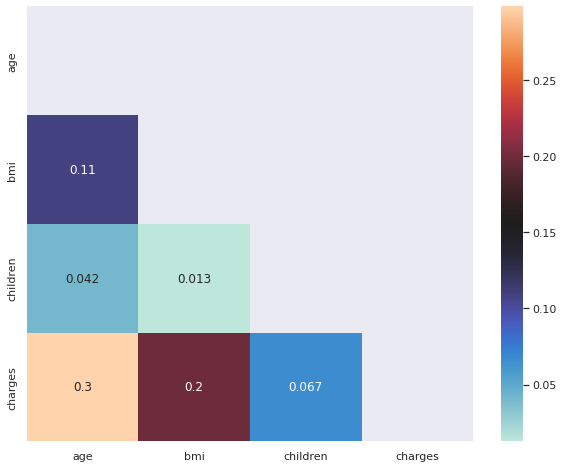

In [111]:
mask = np.triu(np.ones_like(df.corr(), dtype = np.bool))
sns.heatmap(df.corr(), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

### Apparently, the most correlated is age.

## Categorical variables

### I create some graphs to go deeper into the data

### Region

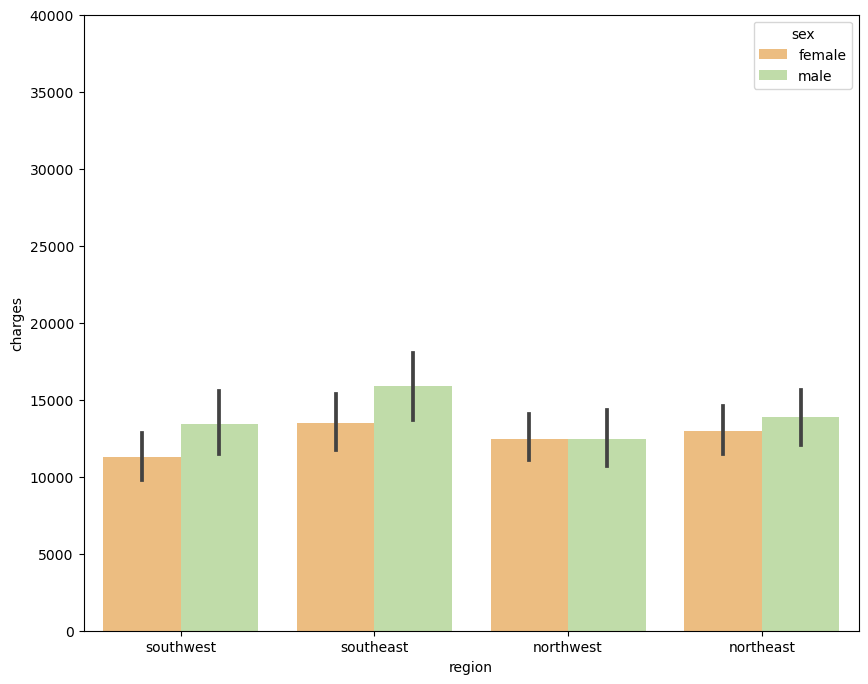

In [59]:
sns.barplot(x='region', y='charges', hue='sex', data=df, palette='Spectral')
plt.ylim(0,40000);

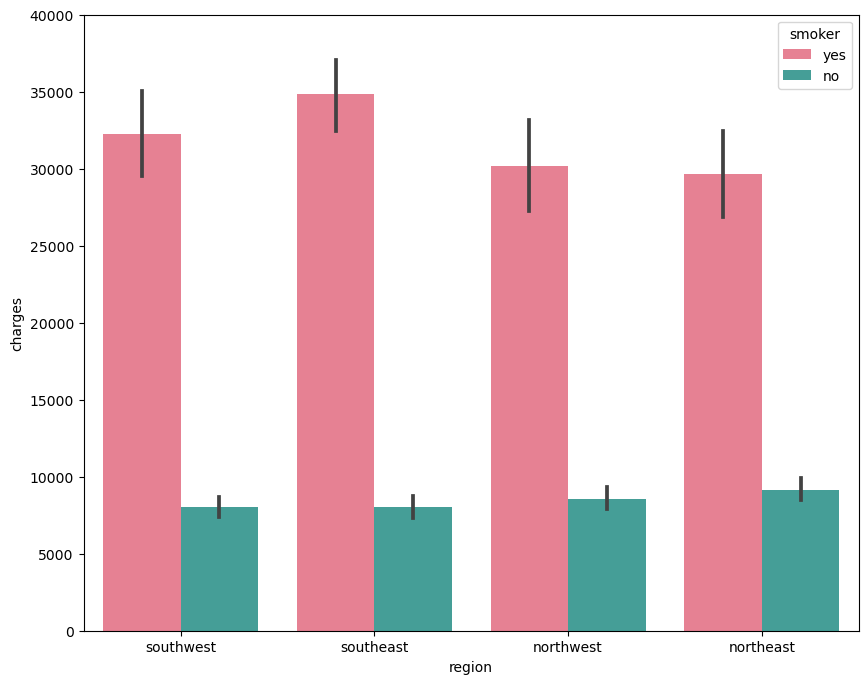

In [60]:
sns.barplot(x = 'region', y = 'charges',
                 hue='smoker', data=df, palette='husl')
plt.ylim(0,40000);

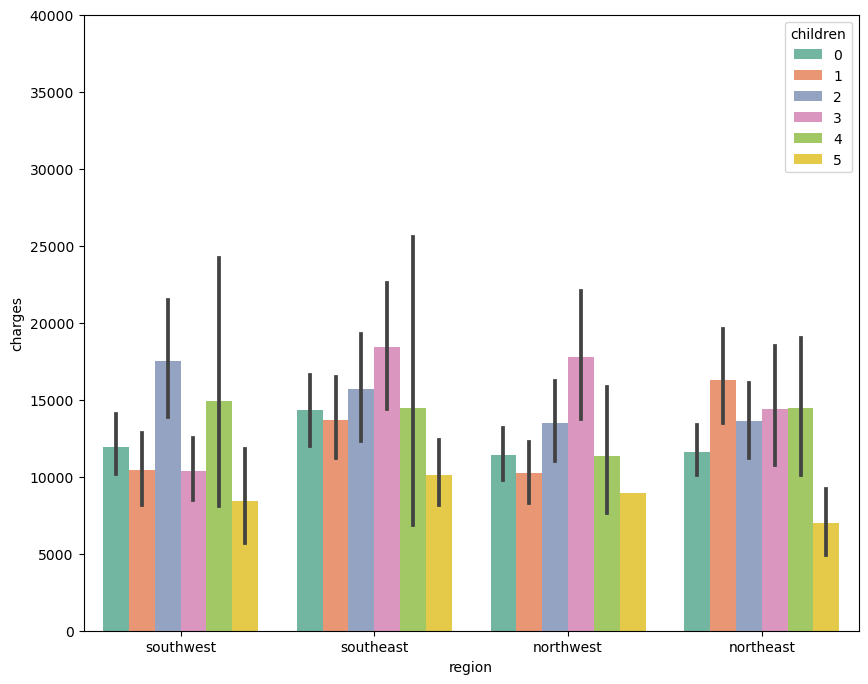

In [61]:
sns.barplot(x='region', y='charges', hue='children', data=df, palette='Set2')
plt.ylim(0,40000);

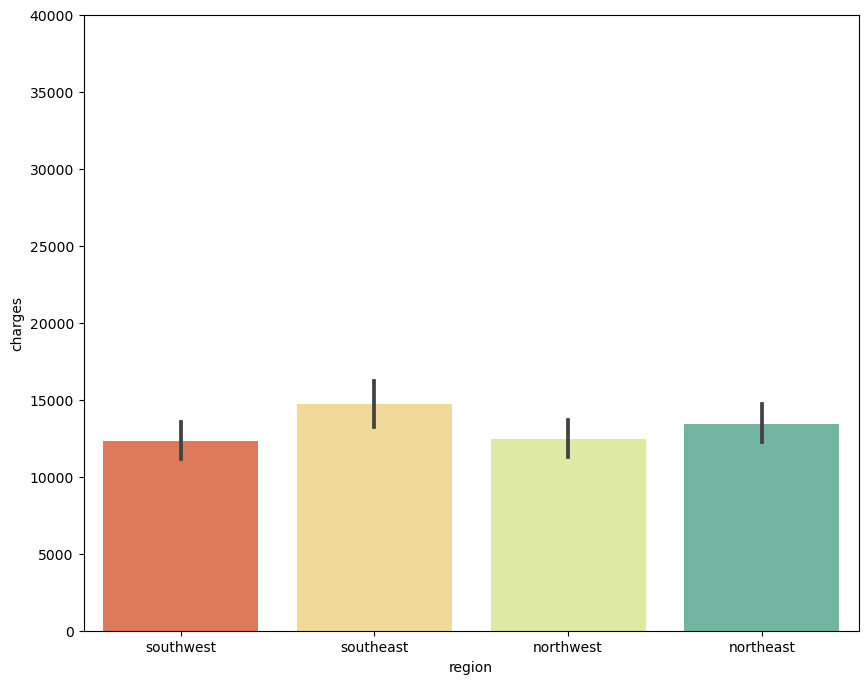

In [62]:
sns.barplot(x='region', y='charges', data=df, palette='Spectral')
plt.ylim(0,40000);

We see that there is a certain relationship between region and premiums, but it is not very pronounced and we do not see too much logic in the relationship at the moment, we already see differences in smoking habits.

---

### Children

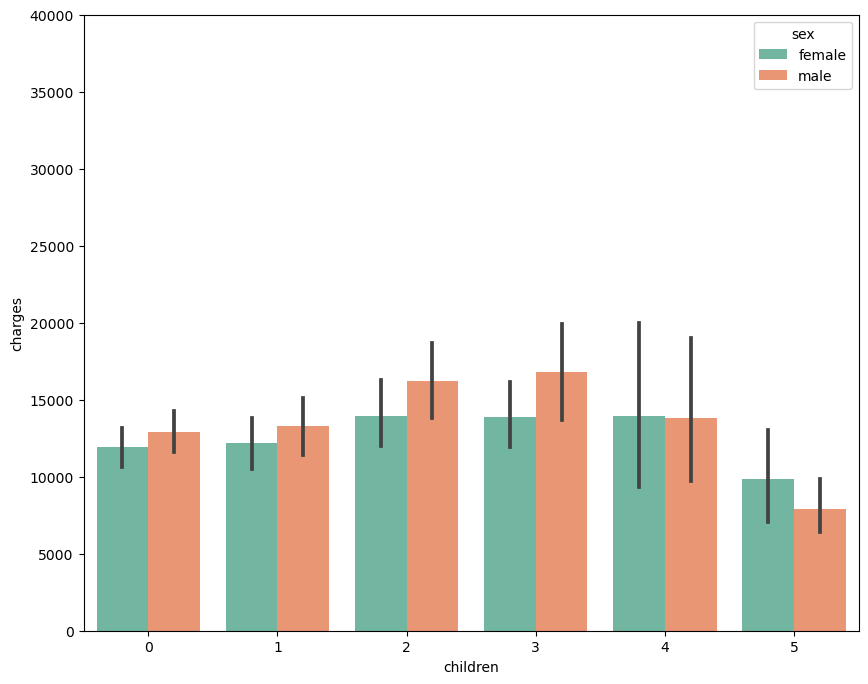

In [63]:
sns.barplot(x='children', y='charges', hue='sex', data=df, palette='Set2')
plt.ylim(0,40000);

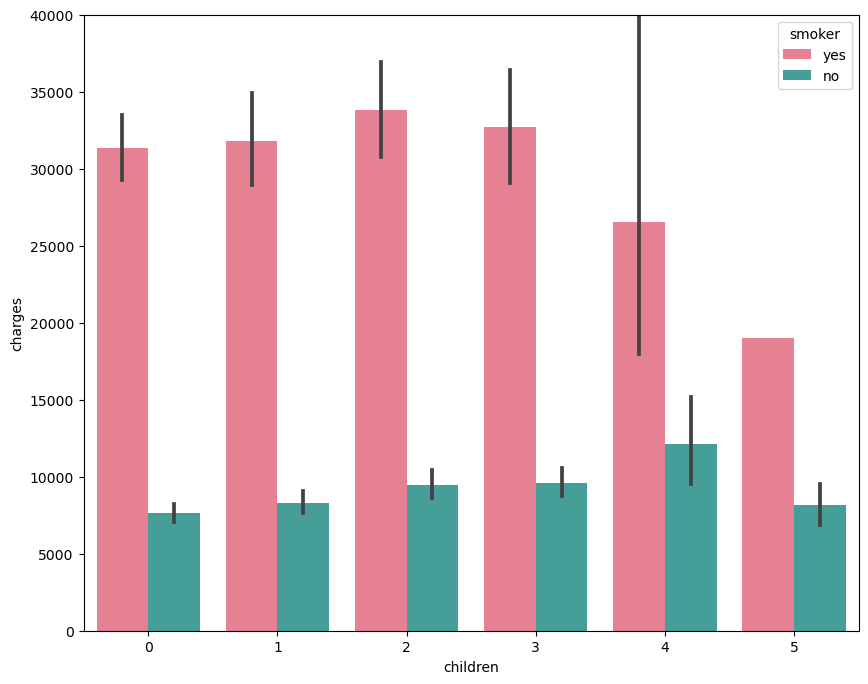

In [64]:
sns.barplot(x = 'children', y = 'charges',
                 hue='smoker', data=df, palette='husl')
plt.ylim(0,40000);

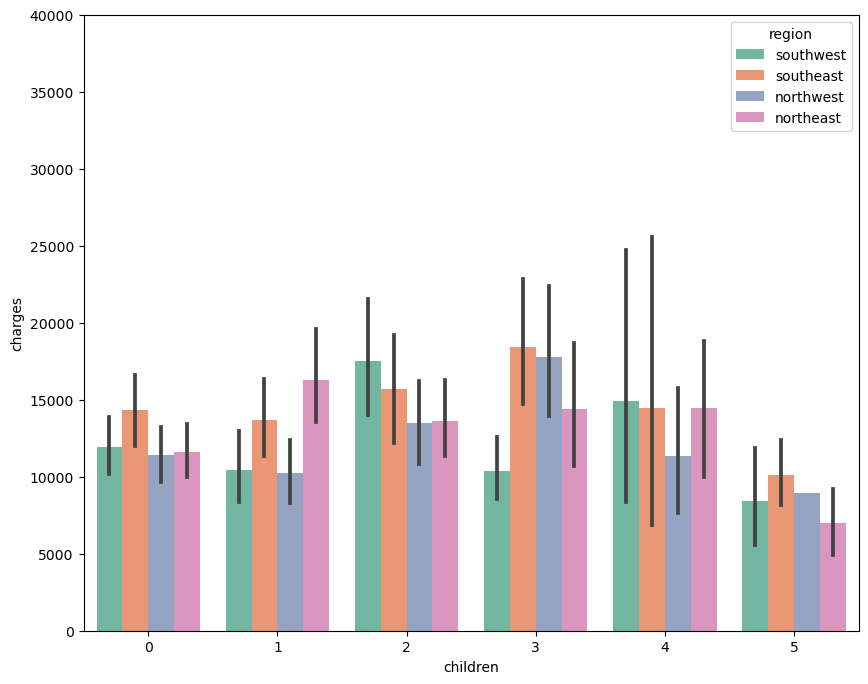

In [65]:
sns.barplot(x='children', y='charges', hue='region', data=df, palette='Set2')
plt.ylim(0,40000);

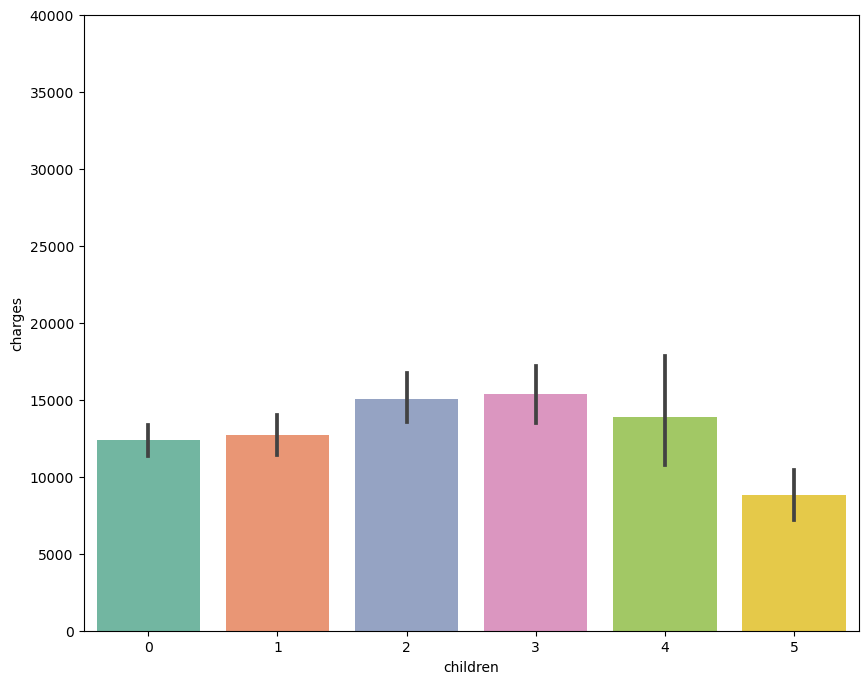

In [66]:
sns.barplot(x='children', y='charges', data=df, palette='Set2')
plt.ylim(0,40000);

We can see that the premiums from 0 to 3 dependents are in increasing order of premiums, but from 3 onwards, they start to decrease, and the relationship is not clear either.

---

### Smoker

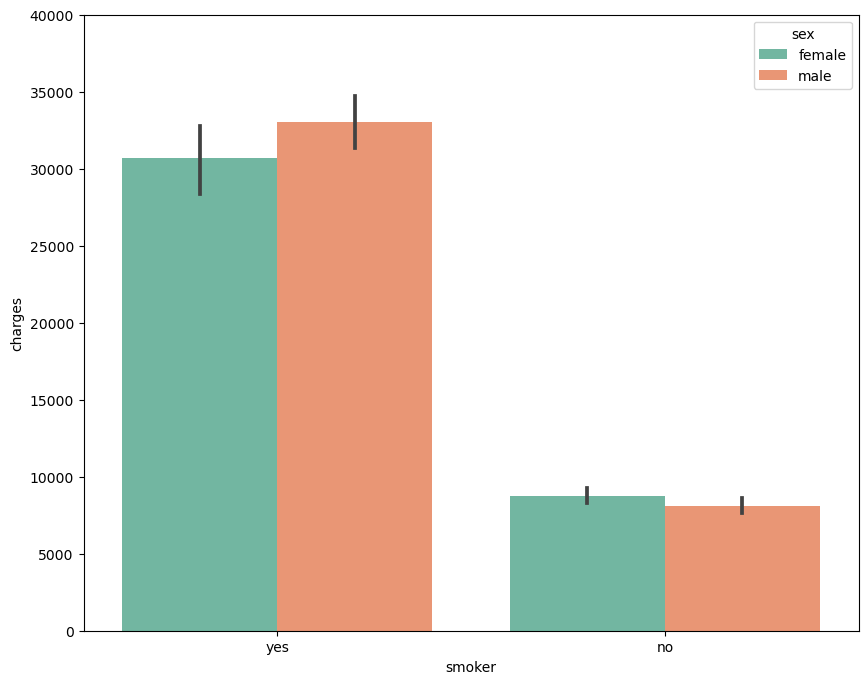

In [67]:
sns.barplot(x='smoker', y='charges', hue='sex', data=df, palette='Set2')
plt.ylim(0,40000);

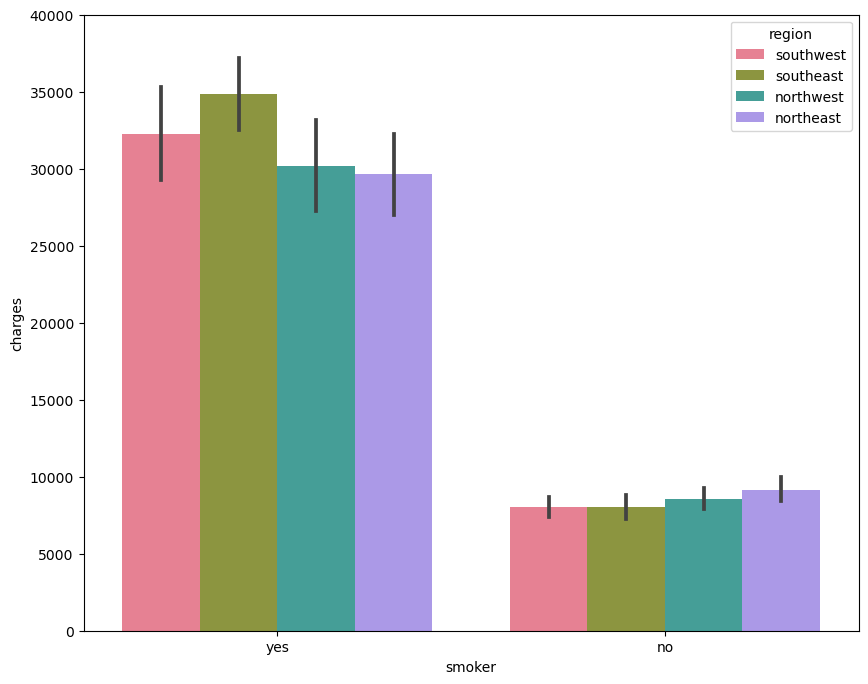

In [68]:
sns.barplot(x = 'smoker', y = 'charges',
                 hue='region', data=df, palette='husl')
plt.ylim(0,40000);

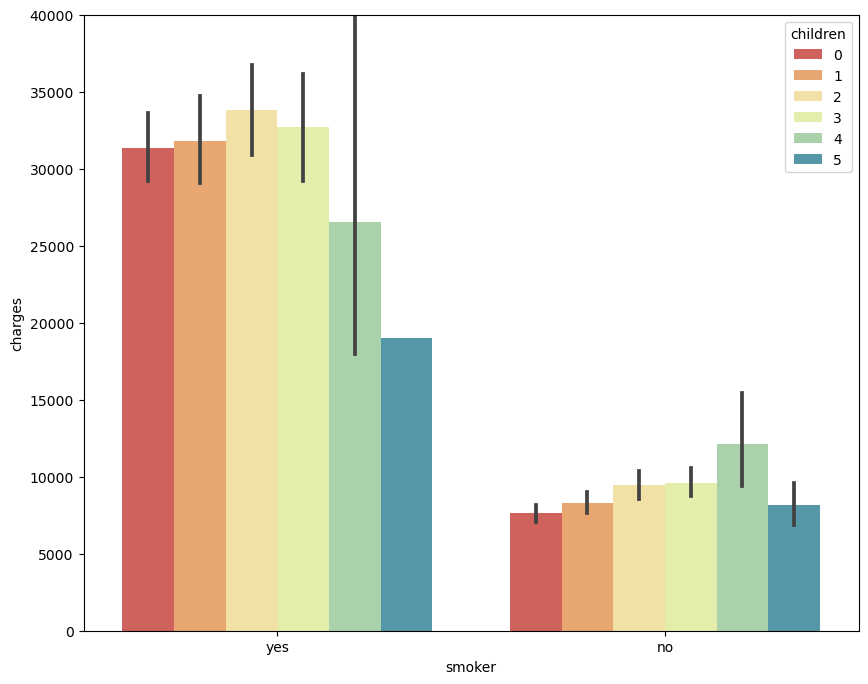

In [69]:
sns.barplot(x='smoker', y='charges', hue='children', data=df, palette='Spectral')
plt.ylim(0,40000);

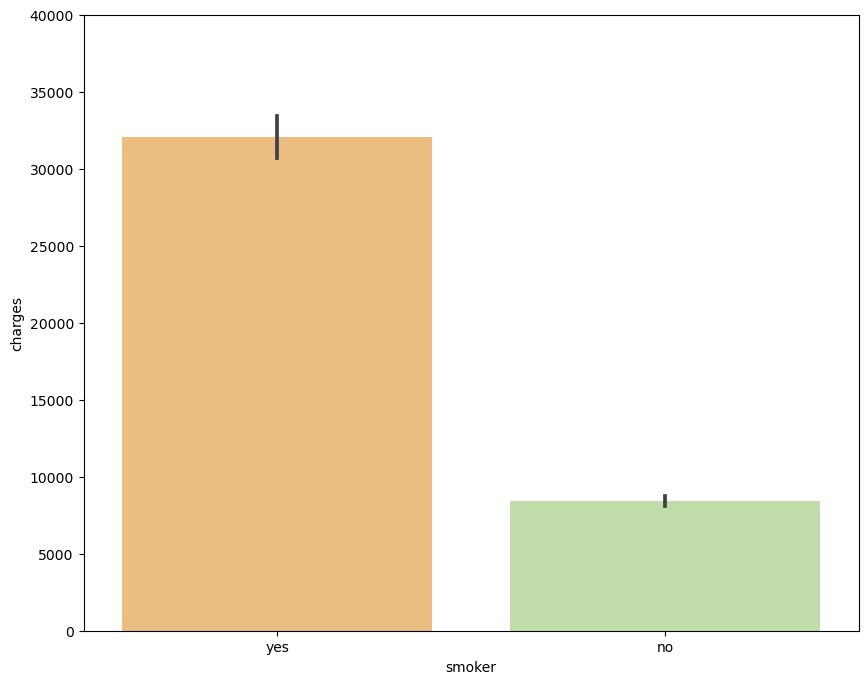

In [70]:
sns.barplot(x='smoker', y='charges', data=df, palette='Spectral')
plt.ylim(0,40000);

We see a fairly clear relationship with smoking habits and the amount of premiums.

### Sex

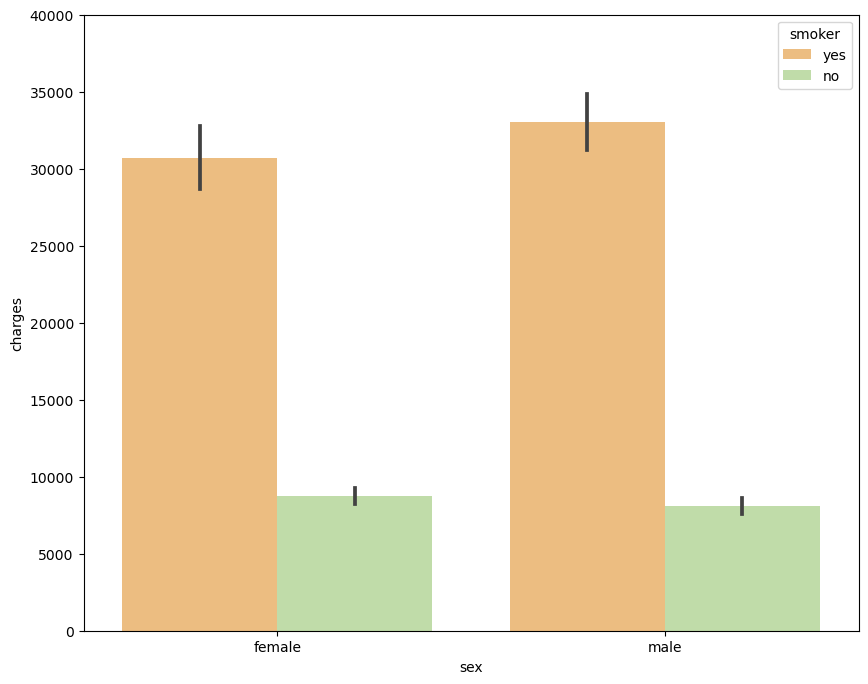

In [71]:
sns.barplot(x='sex', y='charges',hue='smoker' ,data=df, palette='Spectral')
plt.ylim(0,40000);


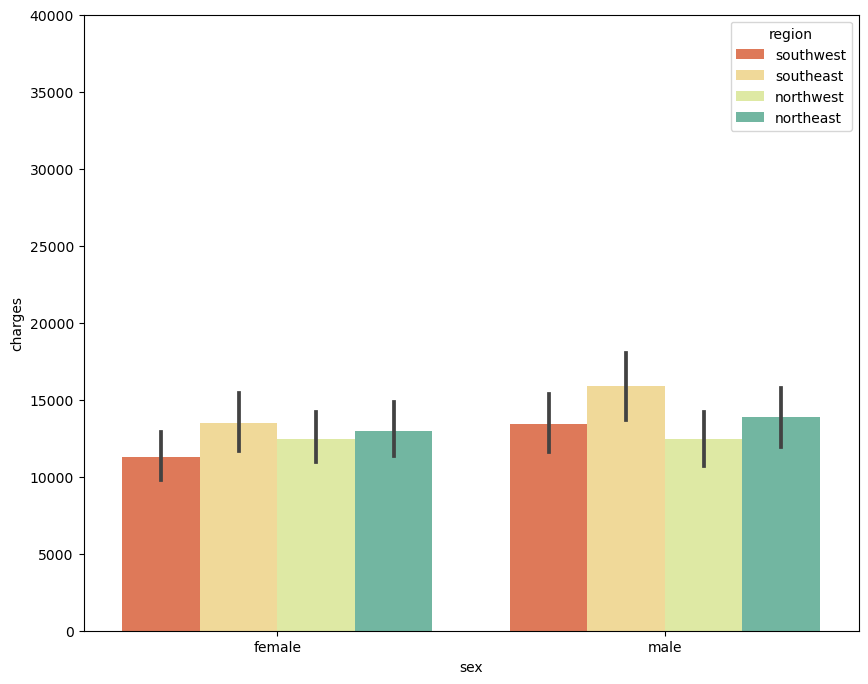

In [80]:
sns.barplot(x='sex', y='charges',hue='region', data=df, palette='Spectral')
plt.ylim(0,40000);

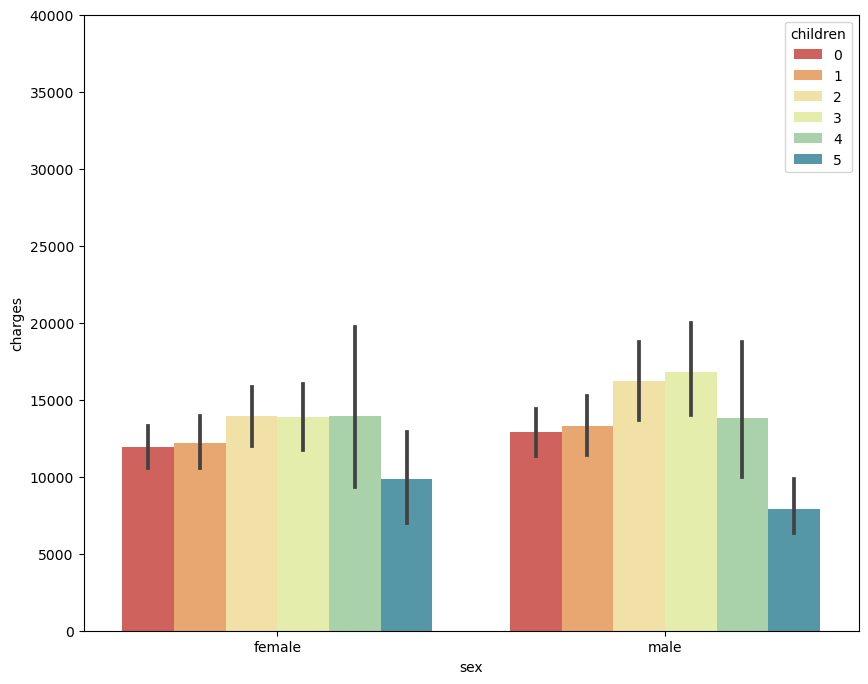

In [81]:
sns.barplot(x='sex', y='charges',hue='children' ,data=df, palette='Spectral')
plt.ylim(0,40000);

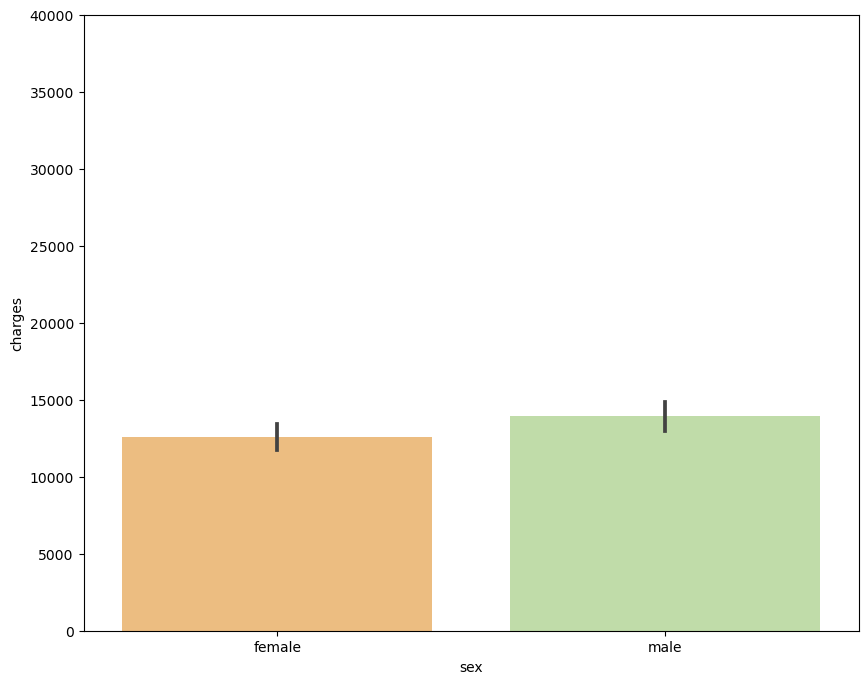

In [82]:
sns.barplot(x='sex', y='charges' ,data=df, palette='Spectral')
plt.ylim(0,40000);

Slight variation by region, but clear variation by smoking status

---

BMI <25

In [21]:
df_peso=df[df['bmi']<25]

In [23]:
df.shape

(1337, 7)

In [22]:
df_peso.shape #son un total de 245 registros sin sobrepeso

(245, 7)

In [26]:
df_peso.describe(include='all')#190 registros de fumadores y el 75% tienen primas de hasta 14572, 
#estarian casi todos dentro del grupo de primas bajas.

age     sex         bmi    children smoker     region  \
count   245.000000     245  245.000000  245.000000    245        245   
unique         NaN       2         NaN         NaN      2          4   
top            NaN  female         NaN         NaN     no  northeast   
freq           NaN     129         NaN         NaN    190         83   
mean     36.375510     NaN   22.203898    1.122449    NaN        NaN   
std      13.606811     NaN    2.103806    1.238598    NaN        NaN   
min      18.000000     NaN   15.960000    0.000000    NaN        NaN   
25%      24.000000     NaN   20.800000    0.000000    NaN        NaN   
50%      35.000000     NaN   22.705000    1.000000    NaN        NaN   
75%      47.000000     NaN   23.900000    2.000000    NaN        NaN   
max      64.000000     NaN   24.985000    5.000000    NaN        NaN   

             charges  
count     245.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    10282.224474  
std      7520.485850  
min      1121.873900  
25%      3861.209650  
50%      8582.302300  
75%     14571.890800  
max     35069.374520

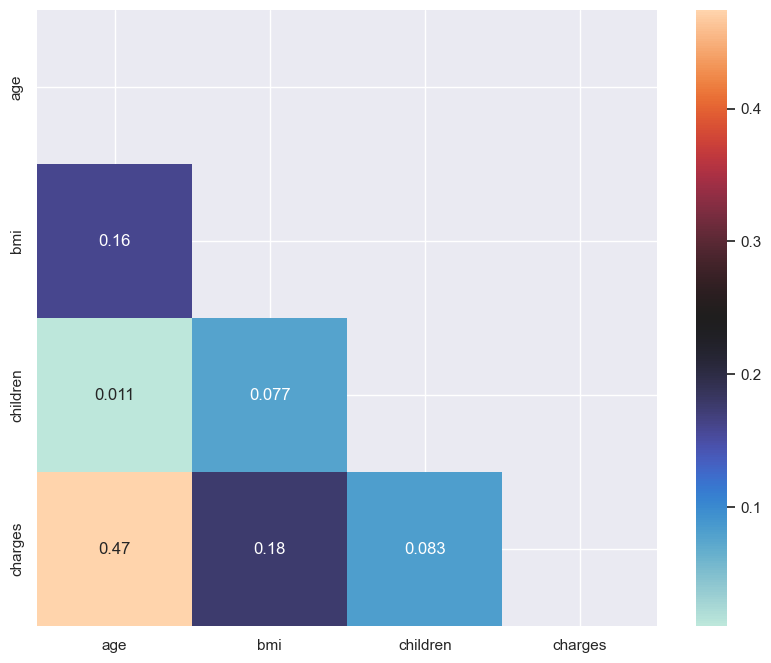

In [106]:
mask = np.triu(np.ones_like(df_peso.corr(), dtype = np.bool))
sns.heatmap(df_peso.corr(), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

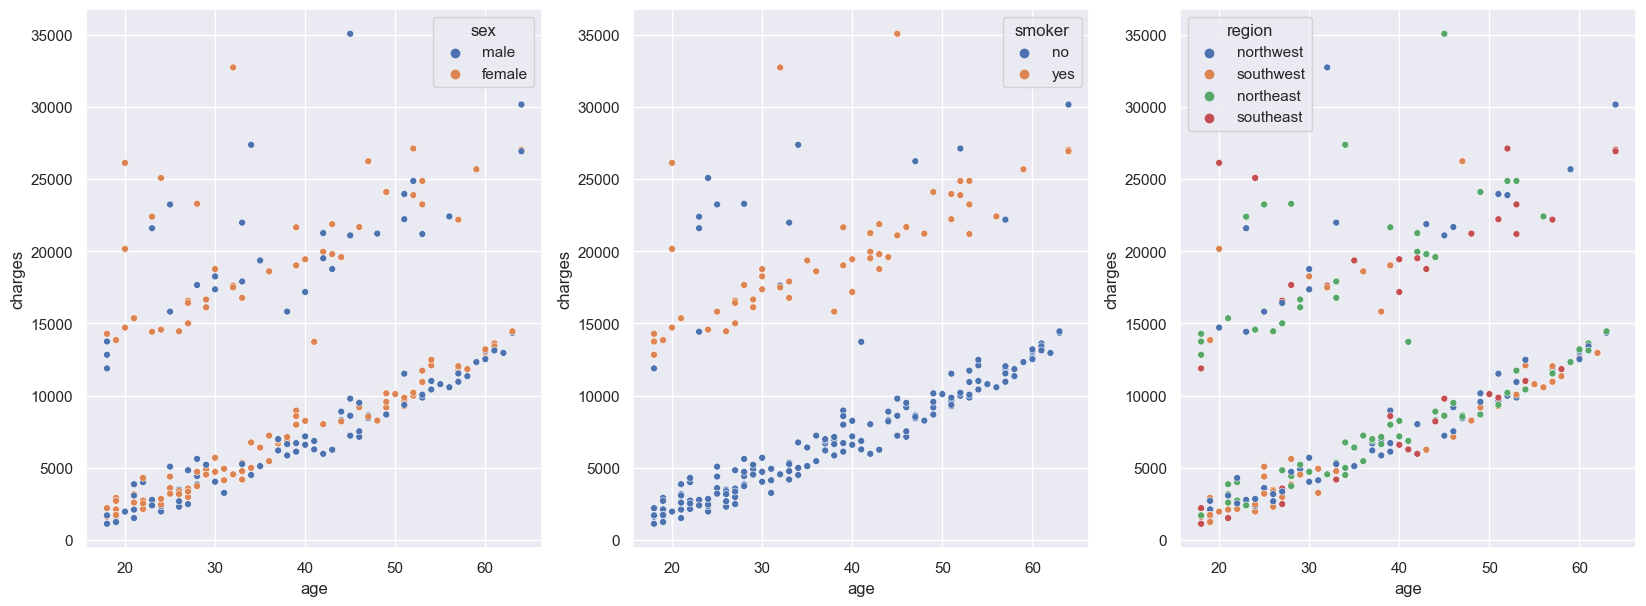

In [110]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df_peso.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='age', y='charges', data = df_peso,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

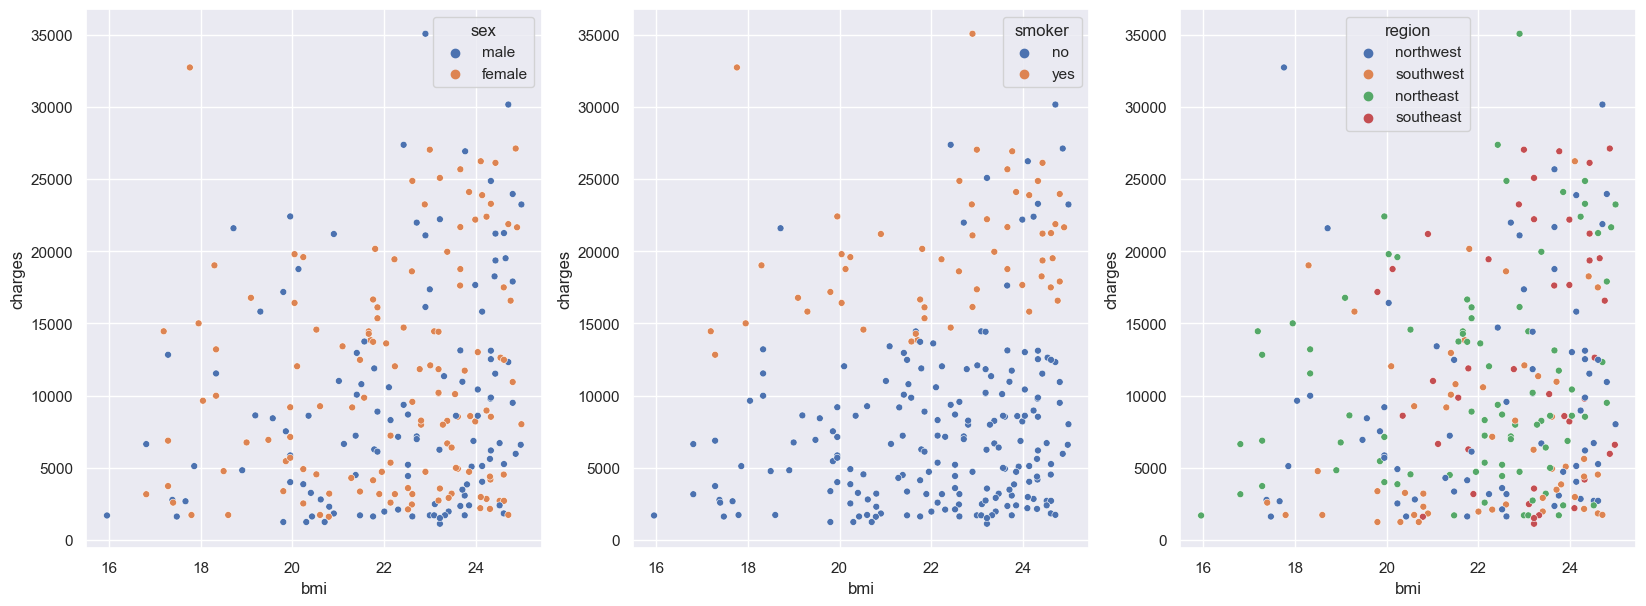

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df_peso.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='bmi', y='charges', data = df_peso,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

### En el caso de BMI saludables, hay clara tendencia a subir primas con la edad, y a la vez, vemos que tambien depende del habito tabaquico, claramente son mas altas cuando se fuma en todas las edades. Hemos perdido la banda mas alta de cargos, por lo que asumimos, que el factor BMI no saludable nos condiciona esa franja.

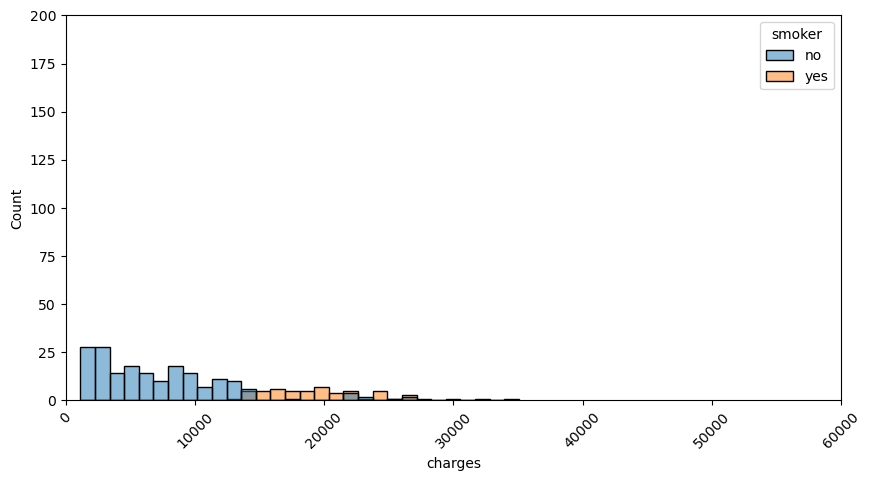

In [53]:
plt.figure(figsize = (10,5)) 
sns.histplot(data =df_peso, x = "charges", hue = "smoker",bins=30) 
plt.ylim(0,200)
plt.xlim(0,60000)
plt.xticks(rotation = 45);

In [36]:
df_peso_fumador=df_peso[(df_peso['smoker']=='yes')]

In [37]:
df_peso_fumador.describe(include='all')

age     sex        bmi   children smoker     region  \
count   55.000000      55  55.000000  55.000000     55         55   
unique        NaN       2        NaN        NaN      1          4   
top           NaN  female        NaN        NaN    yes  northeast   
freq          NaN      32        NaN        NaN     55         22   
mean    37.309091     NaN  22.277182   1.236364    NaN        NaN   
std     12.480908     NaN   2.182447   1.261446    NaN        NaN   
min     18.000000     NaN  17.195000   0.000000    NaN        NaN   
25%     27.500000     NaN  20.710000   0.000000    NaN        NaN   
50%     38.000000     NaN  22.895000   1.000000    NaN        NaN   
75%     45.500000     NaN  24.130000   2.000000    NaN        NaN   
max     64.000000     NaN  24.890000   5.000000    NaN        NaN   

             charges  
count      55.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    19839.278309  
std      4583.245438  
min     12829.455100  
25%     16499.137025  
50%     19361.998800  
75%     22049.467450  
max     35069.374520

BMI > 25

In [100]:
df_peso2=df[df['bmi']>25]

In [101]:
df_peso2.describe(include='all')

age   sex          bmi     children smoker     region  \
count   1091.000000  1091  1091.000000  1091.000000   1091       1091   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   560          NaN          NaN    872        323   
mean      39.817599   NaN    32.573483     1.089826    NaN        NaN   
std       14.071792   NaN     4.982788     1.199081    NaN        NaN   
min       18.000000   NaN    25.080000     0.000000    NaN        NaN   
25%       27.000000   NaN    28.600000     0.000000    NaN        NaN   
50%       40.000000   NaN    31.900000     1.000000    NaN        NaN   
75%       52.000000   NaN    35.815000     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
count    1091.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    13946.476035  
std     12834.725537  
min      1131.506600  
25%      4889.518150  
50%      9563.029000  
75%     17654.442975  
max     63770.428010

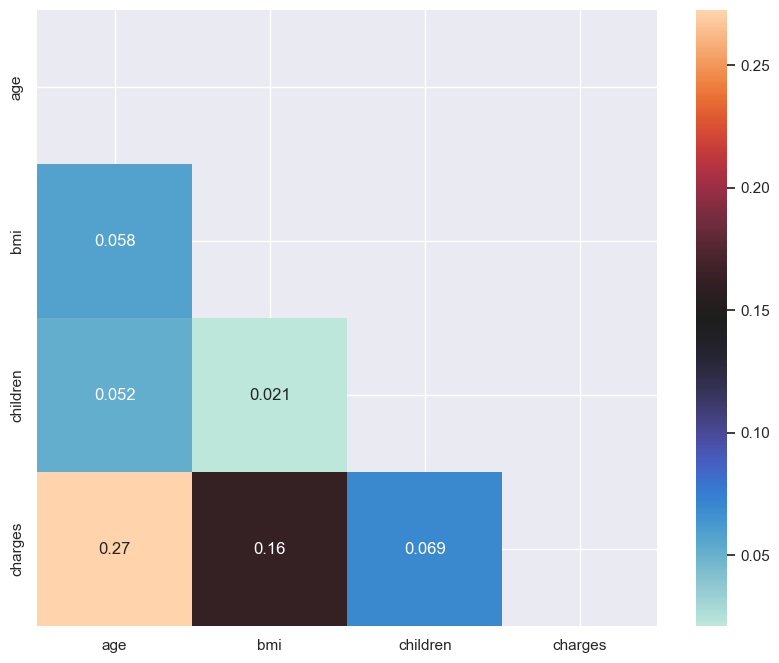

In [107]:
mask = np.triu(np.ones_like(df_peso2.corr(), dtype = np.bool))
sns.heatmap(df_peso2.corr(), 
           cmap = "icefire", 
            mask = mask,
           annot = True);


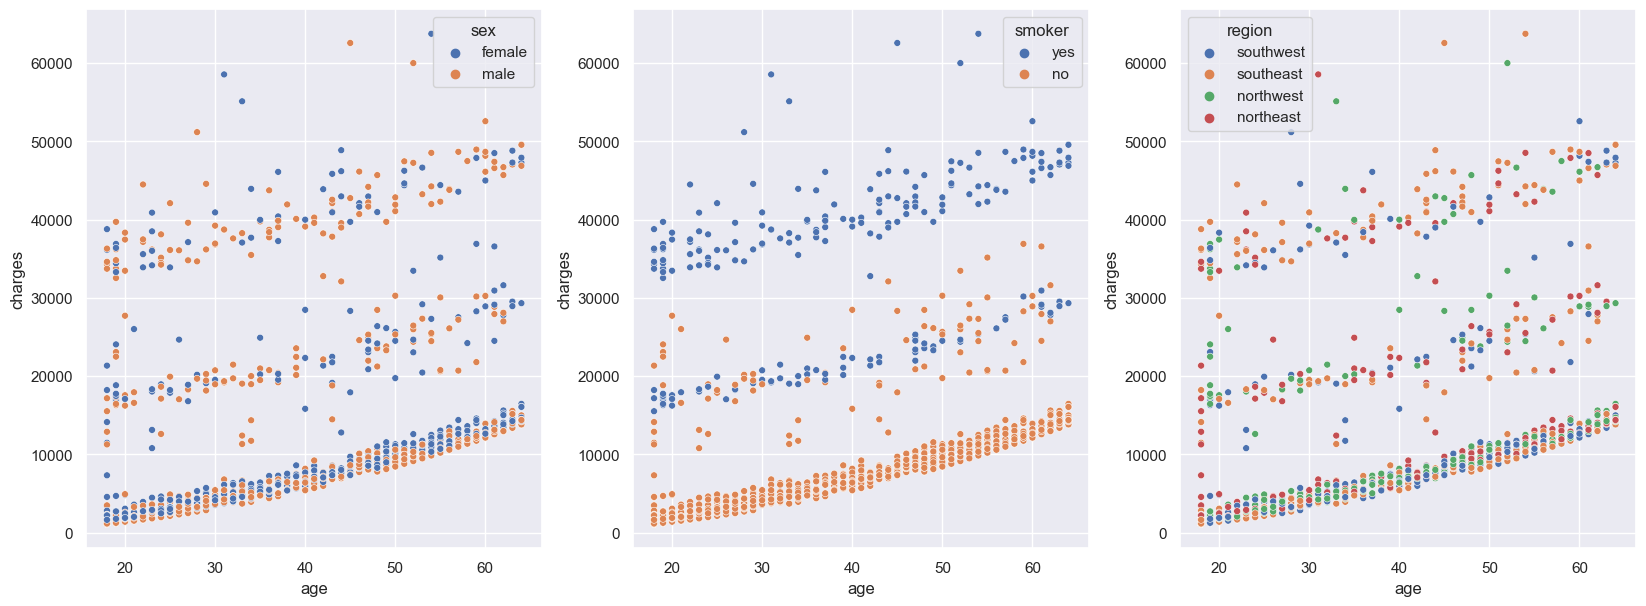

In [108]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df_peso2.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='age', y='charges', data = df_peso2,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

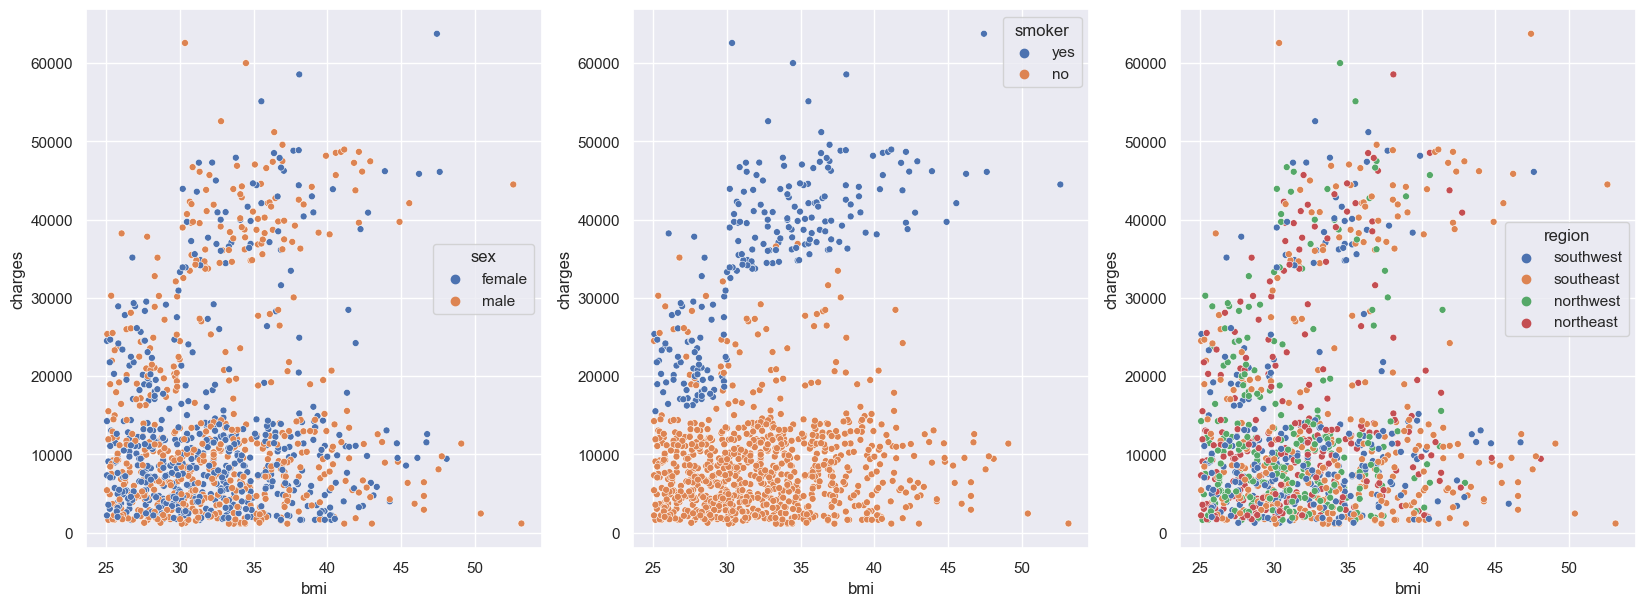

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df_peso2.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='bmi', y='charges', data = df_peso2,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

### En el caso de BMI no saludables, hay clara tendencia a subir primas con la edad, y a la vez, vemos que tambien depende del habito tabaquico, claramente son mas altas cuando se fuma en todas las edades. Vuelve a aparecer la banda mas alta de cargos(exclusiva casi para fumadores), por lo que asumimos, que el primer factor de riesgo para grandes primas es el habito tabaquico (las primas bajas de hasta 15000 simepre corresponden a no fumadores independientemente del BMI) que se agrava con el BMI no saludable y que la tendencia de cargo en los grupos es ascendente segun la edad.

## Por lo que :
- fumador+bmi no slaudable(aumentan con la edad)
- fumador+bmi saludable(aumentan con la edad)
- no fumador+bmi no saludable(aumentan con la edad)
- no fumador+bmi saludable(aumentan con la edad)

## A partir de aqui, quitamos los no fumadores (las primas más bajas solo correlacionadas con la edad), y divido los datos entre BMI saludable o no, para encontrar correlaciones entre variables.

### Vamos a decidir si partir nuestro dataset en base a las variables predictoras que vemos que pueden condicionar nuestra distribución de datos de la variable respuesta, en nuestro caso, vamos a estudiar dividirlo según habitos tabaquicos o según edad.

## Para personas fumadoras 

In [113]:
dffum = df[(df['smoker'] == 'yes')]
dffum.sample(5)

age     sex    bmi  children smoker     region      charges
741    27    male  29.15         0    yes  southeast  18246.49550
82     22    male  37.62         1    yes  southeast  37165.16380
123    44    male  31.35         1    yes  northeast  39556.49450
1303   43    male  27.80         0    yes  southwest  37829.72420
1223   20  female  24.42         0    yes  southeast  26125.67477

In [114]:
numericas1 = dffum.select_dtypes(include = np.number)
numericas1.head(2)

age    bmi  children     charges
0    19  27.90         0  16884.9240
11   62  26.29         0  27808.7251

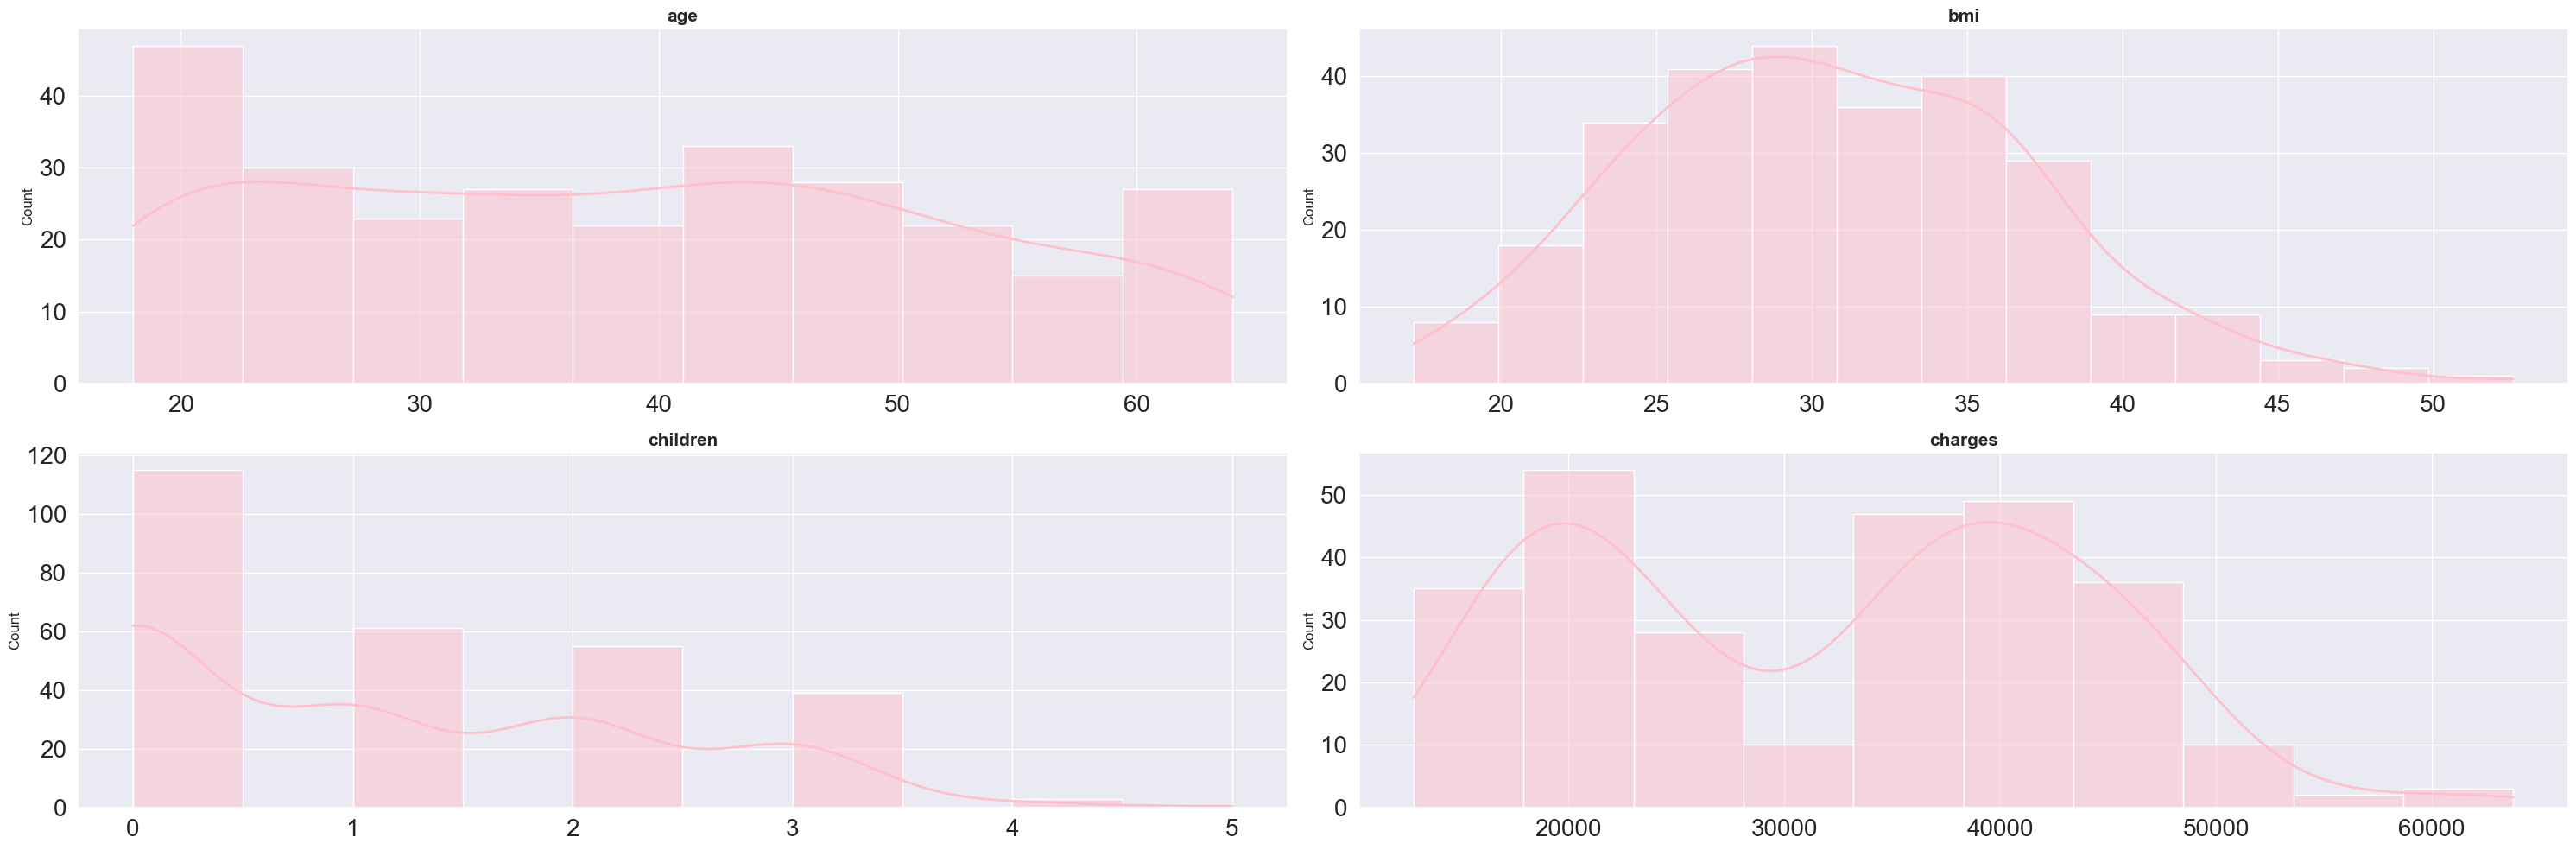

In [115]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas1.columns): 
    sns.histplot(
        data = numericas1[colum],
        kde = True,
        color = "pink", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

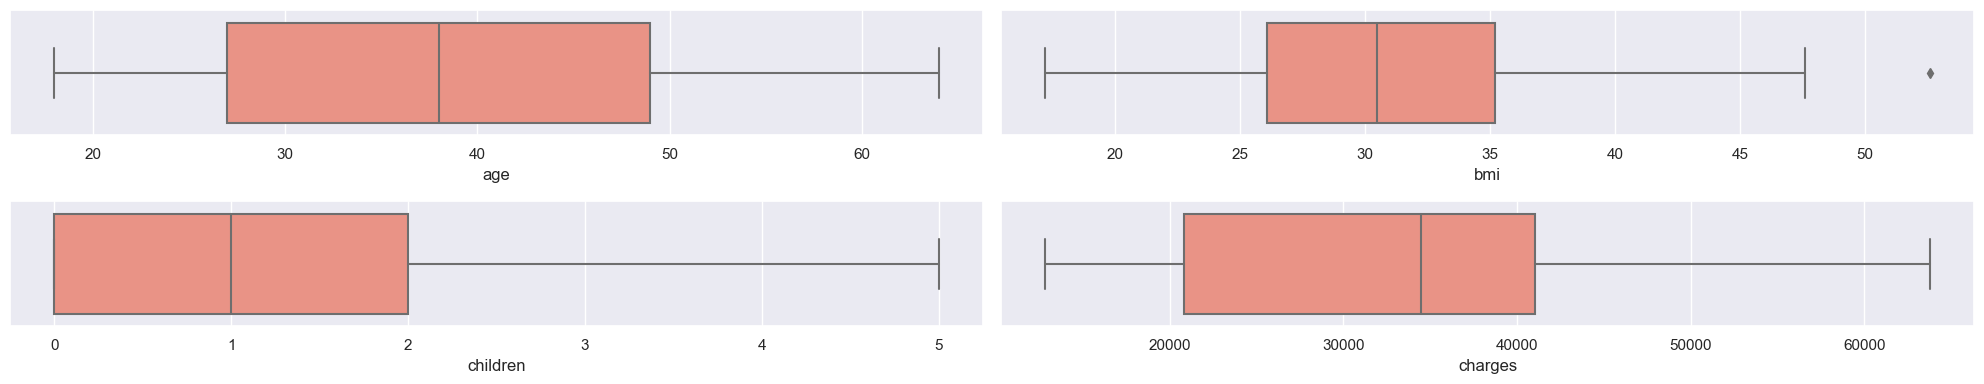

In [116]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas1.columns):
    sns.boxplot(x = numericas1[columna], data = dffum, ax=axes[indice], color = "#fa8775"); # para trazar una línea de densidad 
plt.tight_layout()
plt.show();

In [173]:
dffum.corr(method='spearman')

age       bmi  children   charges
age       1.000000  0.057876  0.111973  0.451876
bmi       0.057876  1.000000  0.011178  0.834228
children  0.111973  0.011178  1.000000  0.086998
charges   0.451876  0.834228  0.086998  1.000000

In [172]:
pg.partial_corr(data=dffum, x='age', y='charges', covar='bmi', method='spearman')

n         r         CI95%         p-val
spearman  274  0.733146  [0.67, 0.78]  2.759257e-47

In [171]:
pg.partial_corr(data=dffum, x='bmi', y='charges', covar='age', method='spearman')

n         r         CI95%          p-val
spearman  274  0.907352  [0.88, 0.93]  5.387764e-104

Las tres variables estan relacionadas entre si, bloqueandolas alternativamente, las correlaciones positivas con cargos aumentan

# BMI saludable

In [117]:

dffum_saludable=dffum[dffum['bmi']<25]

In [118]:
dffum_saludable.describe(include='all')

age     sex        bmi   children smoker     region  \
count   55.000000      55  55.000000  55.000000     55         55   
unique        NaN       2        NaN        NaN      1          4   
top           NaN  female        NaN        NaN    yes  northeast   
freq          NaN      32        NaN        NaN     55         22   
mean    37.309091     NaN  22.277182   1.236364    NaN        NaN   
std     12.480908     NaN   2.182447   1.261446    NaN        NaN   
min     18.000000     NaN  17.195000   0.000000    NaN        NaN   
25%     27.500000     NaN  20.710000   0.000000    NaN        NaN   
50%     38.000000     NaN  22.895000   1.000000    NaN        NaN   
75%     45.500000     NaN  24.130000   2.000000    NaN        NaN   
max     64.000000     NaN  24.890000   5.000000    NaN        NaN   

             charges  
count      55.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    19839.278309  
std      4583.245438  
min     12829.455100  
25%     16499.137025  
50%     19361.998800  
75%     22049.467450  
max     35069.374520

In [124]:
numericas_fum_saludables = dffum_saludable.select_dtypes(include = np.number)
numericas_fum_saludables.head(2)

age    bmi  children     charges
58   53  22.88         1  23244.7902
64   20  22.42         0  14711.7438

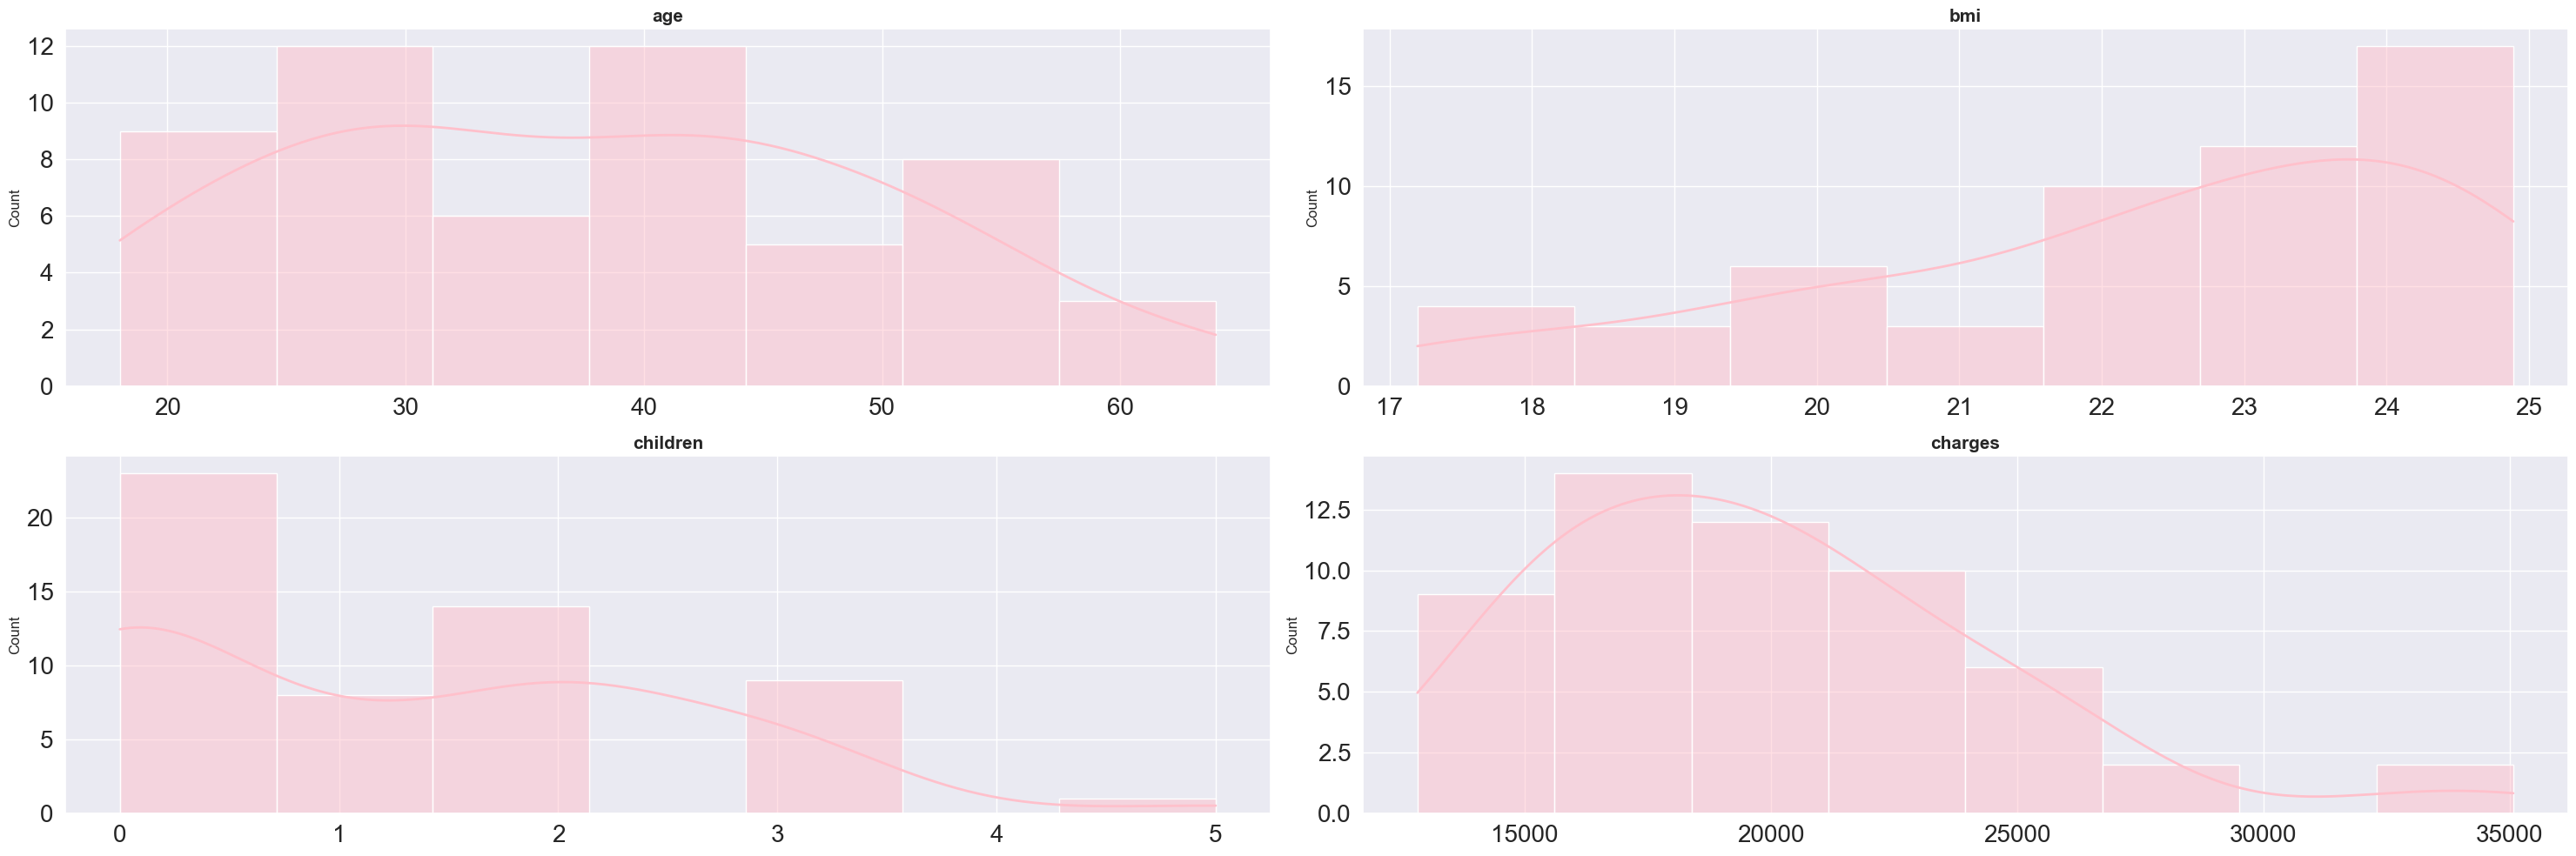

In [125]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas_fum_saludables.columns): 
    sns.histplot(
        data = numericas_fum_saludables[colum],
        kde = True,
        color = "pink", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

In [158]:
shapiro_test = stats.shapiro(numericas_fum_saludables.age)
print(f"Variable age: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_fum_saludables.bmi)
print(f"Variable bmi: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_fum_saludables.charges)
print(f"Variable charges: {shapiro_test}")

Variable age: ShapiroResult(statistic=0.9636784195899963, pvalue=0.09510397911071777)
Variable bmi: ShapiroResult(statistic=0.9075034856796265, pvalue=0.00045880640391260386)
Variable charges: ShapiroResult(statistic=0.9331294298171997, pvalue=0.004410581663250923)


In [159]:
k2, p_value = stats.normaltest(numericas_fum_saludables.age)
print(f"Variable age: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_fum_saludables.bmi)
print(f"Variable bmi: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_fum_saludables.charges)
print(f"Variable charges: Estadítico = {k2}, p-value = {p_value}")

Variable age: Estadítico = 3.7841944401285836, p-value = 0.15075531000758297
Variable bmi: Estadítico = 5.767728447442714, p-value = 0.055918264121129095
Variable charges: Estadítico = 13.320477515883951, p-value = 0.0012808405230266449


In [142]:
numericas_fum_saludables = dffum_saludable.select_dtypes(include = np.number)
numericas_fum_saludables.head(2)

age    bmi  children     charges
58   53  22.88         1  23244.7902
64   20  22.42         0  14711.7438

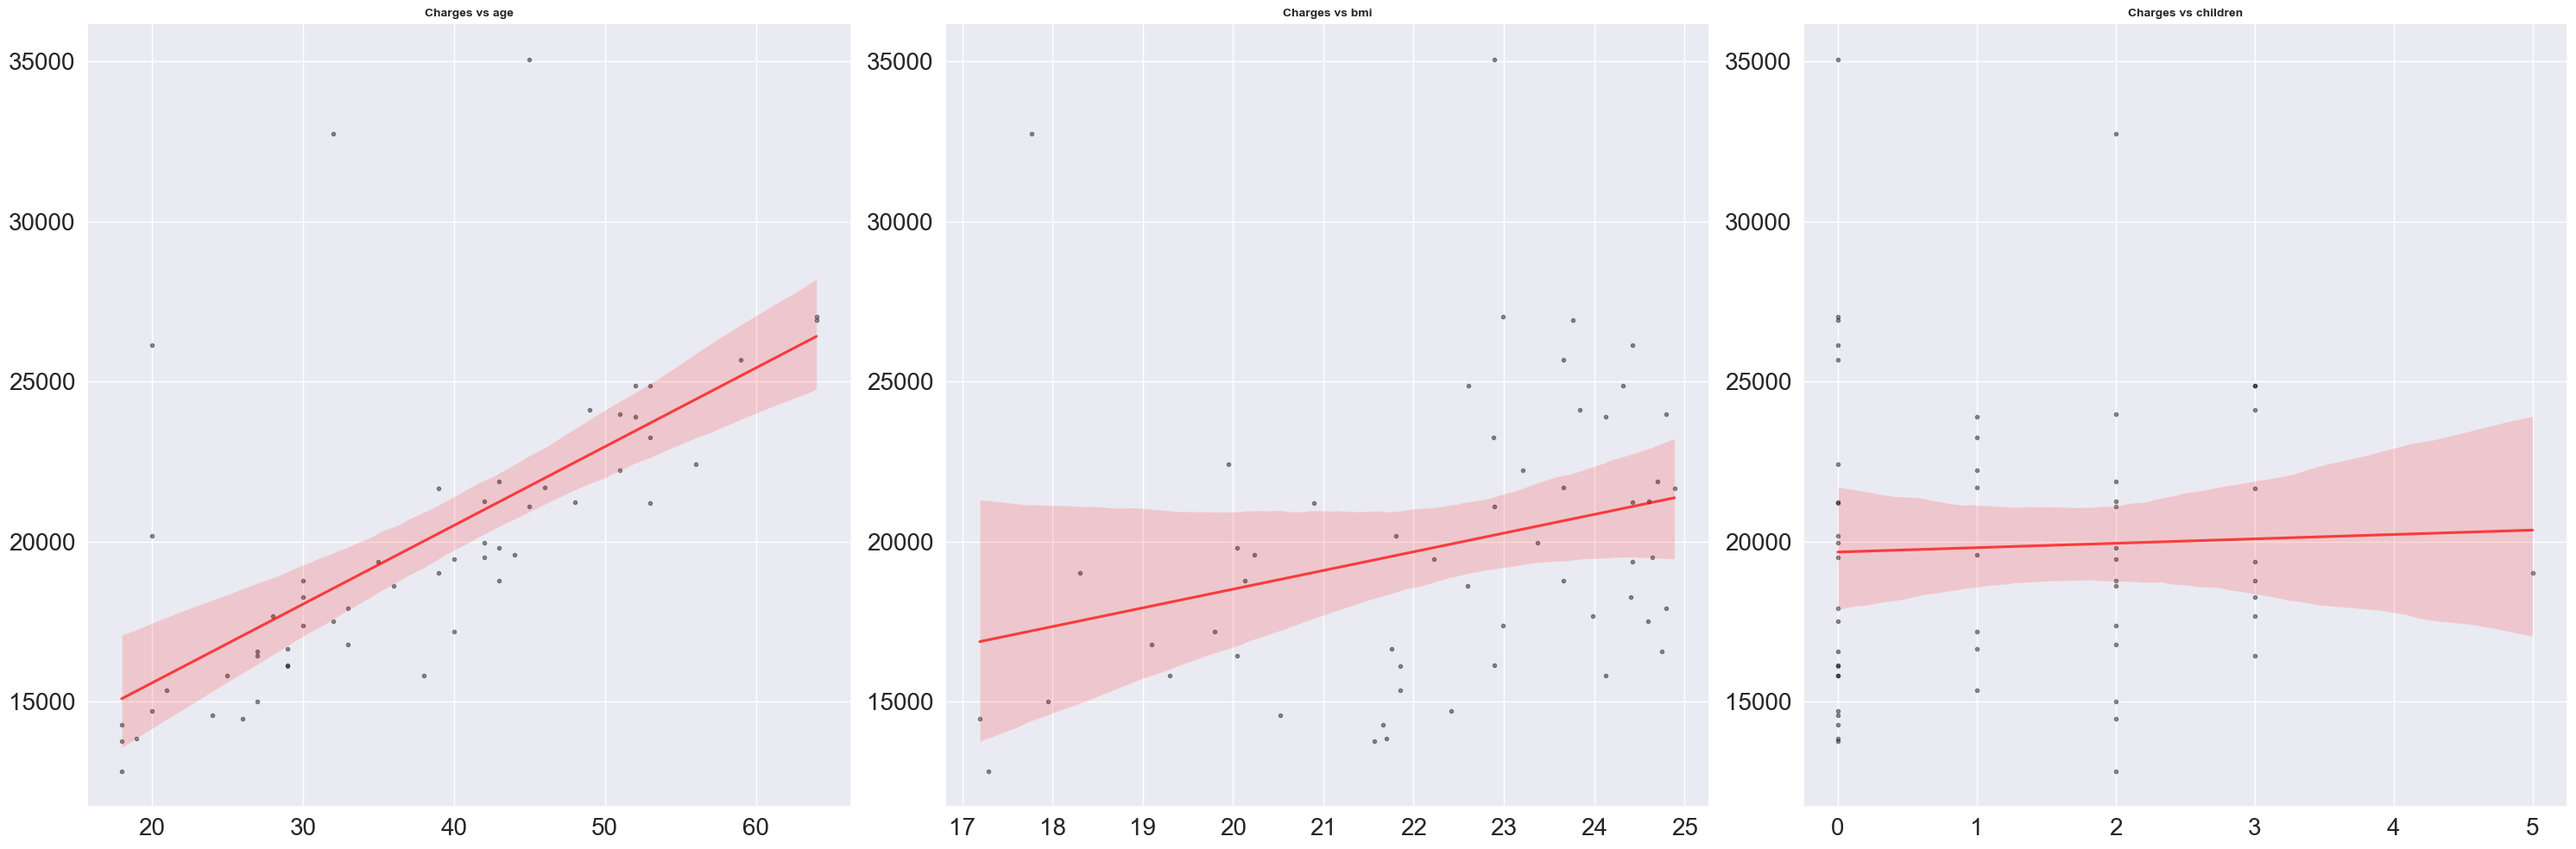

In [143]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
numericas = numericas_fum_saludables.drop("charges", axis=1) 
for i, colum in enumerate(numericas):
    sns.regplot(
        x = dffum_saludable[colum], 
        y = dffum_saludable["charges"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    axes[i].set_title(f"Charges vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();

In [153]:
dffum_saludable.corr(method = 'spearman')

age       bmi  children   charges
age       1.000000  0.245382  0.089837  0.799567
bmi       0.245382  1.000000 -0.036167  0.393844
children  0.089837 -0.036167  1.000000  0.108410
charges   0.799567  0.393844  0.108410  1.000000

In [155]:
dffum_saludable.corr(method = 'pearson')

age       bmi  children   charges
age       1.000000  0.251514  0.048204  0.670269
bmi       0.251514  1.000000 -0.139767  0.278094
children  0.048204 -0.139767  1.000000  0.037743
charges   0.670269  0.278094  0.037743  1.000000

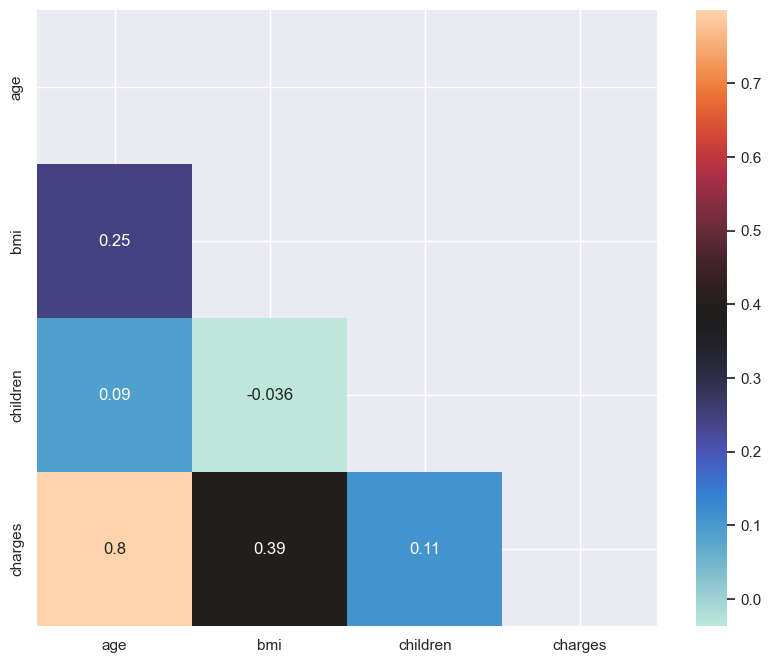

In [154]:
mask = np.triu(np.ones_like(dffum_saludable.corr(method = 'spearman'), dtype = np.bool))
sns.heatmap(dffum_saludable.corr(method = 'spearman'), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

In [167]:
display(pg.corr(dffum_saludable['age'], dffum_saludable['charges'], method='pearson'))
display(pg.corr(dffum_saludable['age'], dffum_saludable['charges'], method='spearman'))
display(pg.corr(dffum_saludable['age'], dffum_saludable['charges'], method='kendall'))

n         r         CI95%         p-val       BF10     power
pearson  55  0.670269  [0.49, 0.79]  2.174499e-08  7.042e+05  0.999958

n         r         CI95%         p-val  power
spearman  55  0.799567  [0.68, 0.88]  2.481337e-13    1.0

n         r         CI95%         p-val     power
kendall  55  0.686903  [0.52, 0.81]  2.265867e-13  0.999984

# BMI NO saludable

In [121]:

dffum_no_saludable=dffum[dffum['bmi']>25]

In [122]:
dffum_no_saludable.describe(include='all')

age   sex         bmi    children smoker     region  \
count   219.000000   219  219.000000  219.000000    219        219   
unique         NaN     2         NaN         NaN      1          4   
top            NaN  male         NaN         NaN    yes  southeast   
freq           NaN   136         NaN         NaN    219         77   
mean     38.817352   NaN   32.825890    1.082192    NaN        NaN   
std      14.273009   NaN    5.136105    1.130317    NaN        NaN   
min      18.000000   NaN   25.100000    0.000000    NaN        NaN   
25%      25.500000   NaN   28.345000    0.000000    NaN        NaN   
50%      38.000000   NaN   32.015000    1.000000    NaN        NaN   
75%      50.000000   NaN   36.080000    2.000000    NaN        NaN   
max      64.000000   NaN   52.580000    4.000000    NaN        NaN   

             charges  
count     219.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    35116.909657  
std     10702.561195  
min     15518.180250  
25%     24601.558775  
50%     37270.151200  
75%     42808.670100  
max     63770.428010

In [138]:
numericas_fum_no_saludables = dffum_no_saludable.select_dtypes(include = np.number)
numericas_fum_no_saludables.head(2)

age    bmi  children     charges
0    19  27.90         0  16884.9240
11   62  26.29         0  27808.7251

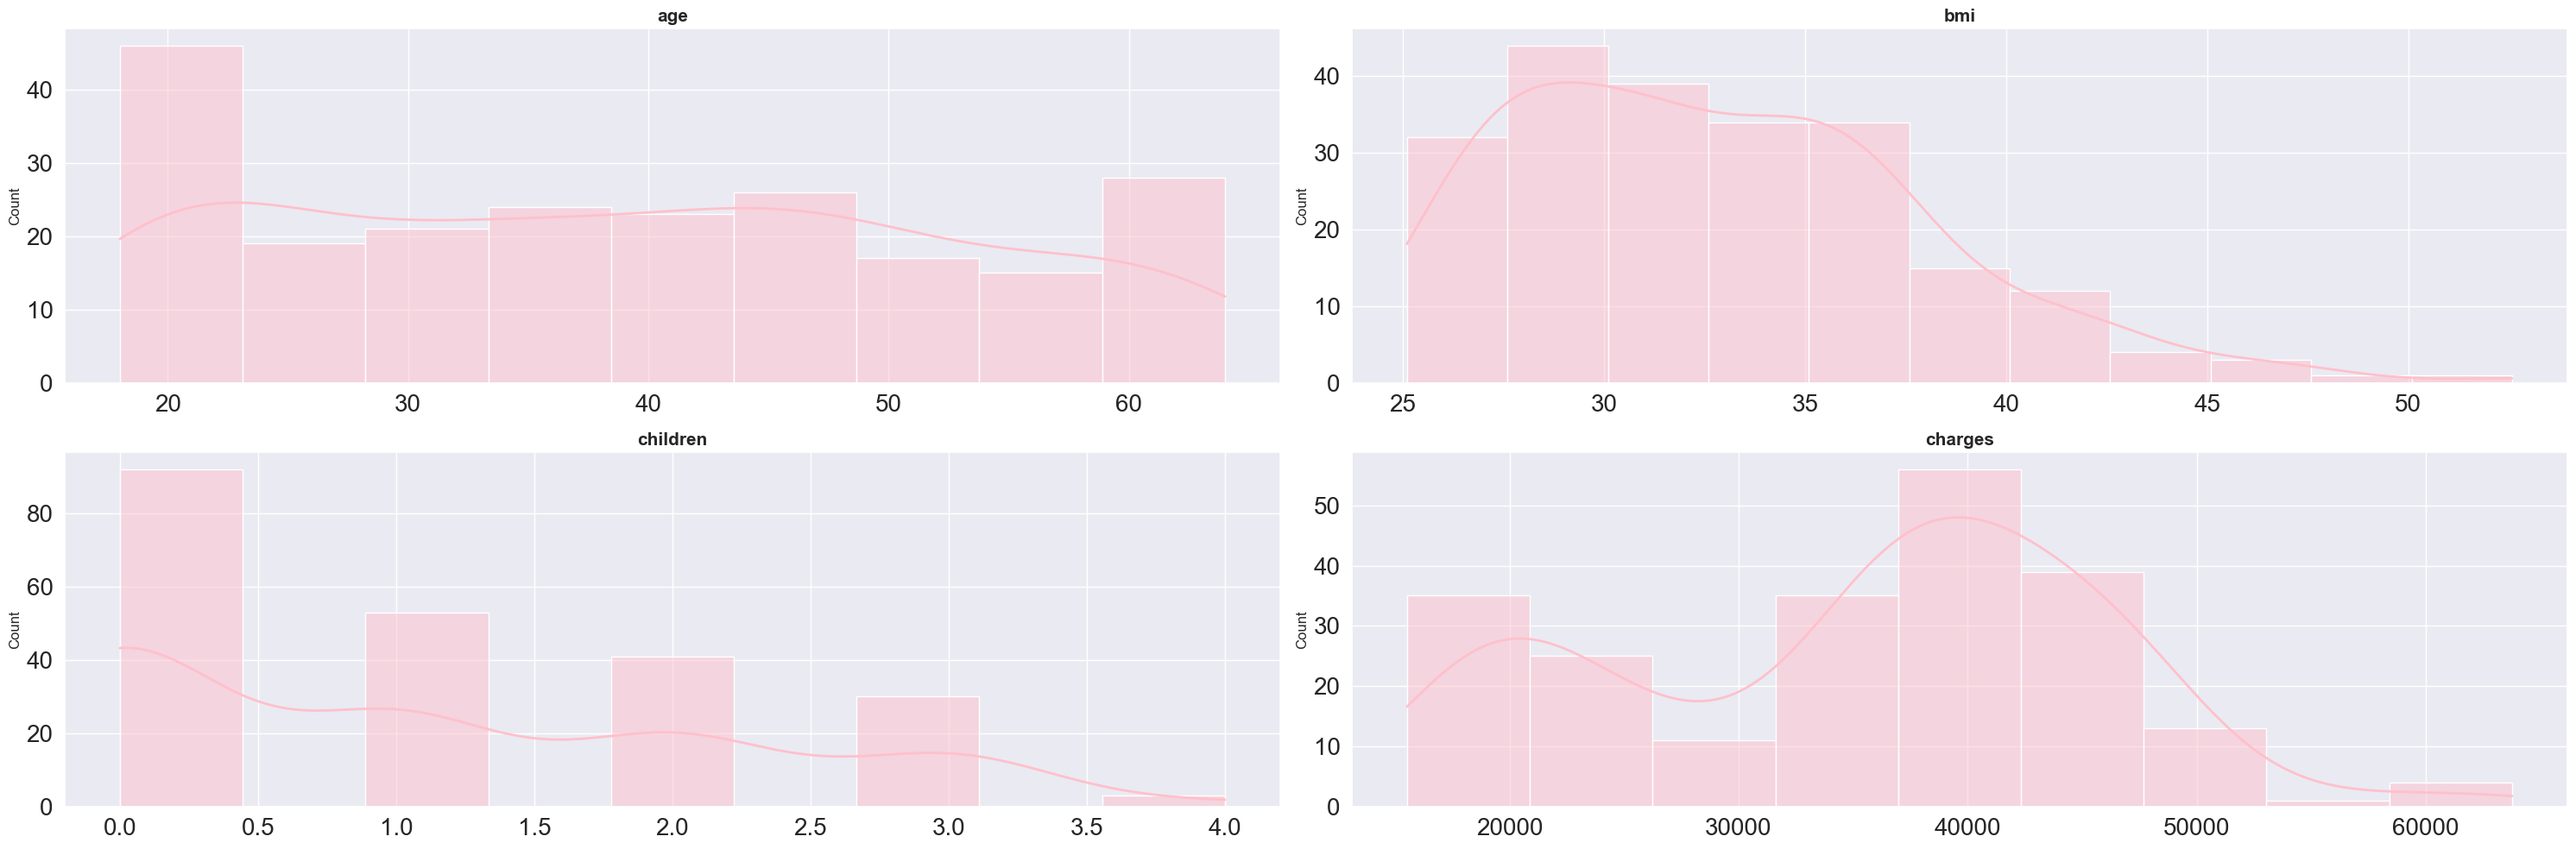

In [139]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas_fum_no_saludables.columns): 
    sns.histplot(
        data = numericas_fum_no_saludables[colum],
        kde = True,
        color = "pink", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

In [160]:
shapiro_test = stats.shapiro(numericas_fum_no_saludables.age)
print(f"Variable age: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_fum_no_saludables.bmi)
print(f"Variable bmi: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_fum_no_saludables.charges)
print(f"Variable charges: {shapiro_test}")

Variable age: ShapiroResult(statistic=0.9417991042137146, pvalue=1.1172188152386298e-07)
Variable bmi: ShapiroResult(statistic=0.9536837935447693, pvalue=1.6536107523279497e-06)
Variable charges: ShapiroResult(statistic=0.9477157592773438, pvalue=4.0925593225438206e-07)


In [161]:
k2, p_value = stats.normaltest(numericas_fum_saludables.age)
print(f"Variable age: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_fum_saludables.bmi)
print(f"Variable bmi: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_fum_saludables.charges)
print(f"Variable charges: Estadítico = {k2}, p-value = {p_value}")

Variable age: Estadítico = 3.7841944401285836, p-value = 0.15075531000758297
Variable bmi: Estadítico = 5.767728447442714, p-value = 0.055918264121129095
Variable charges: Estadítico = 13.320477515883951, p-value = 0.0012808405230266449


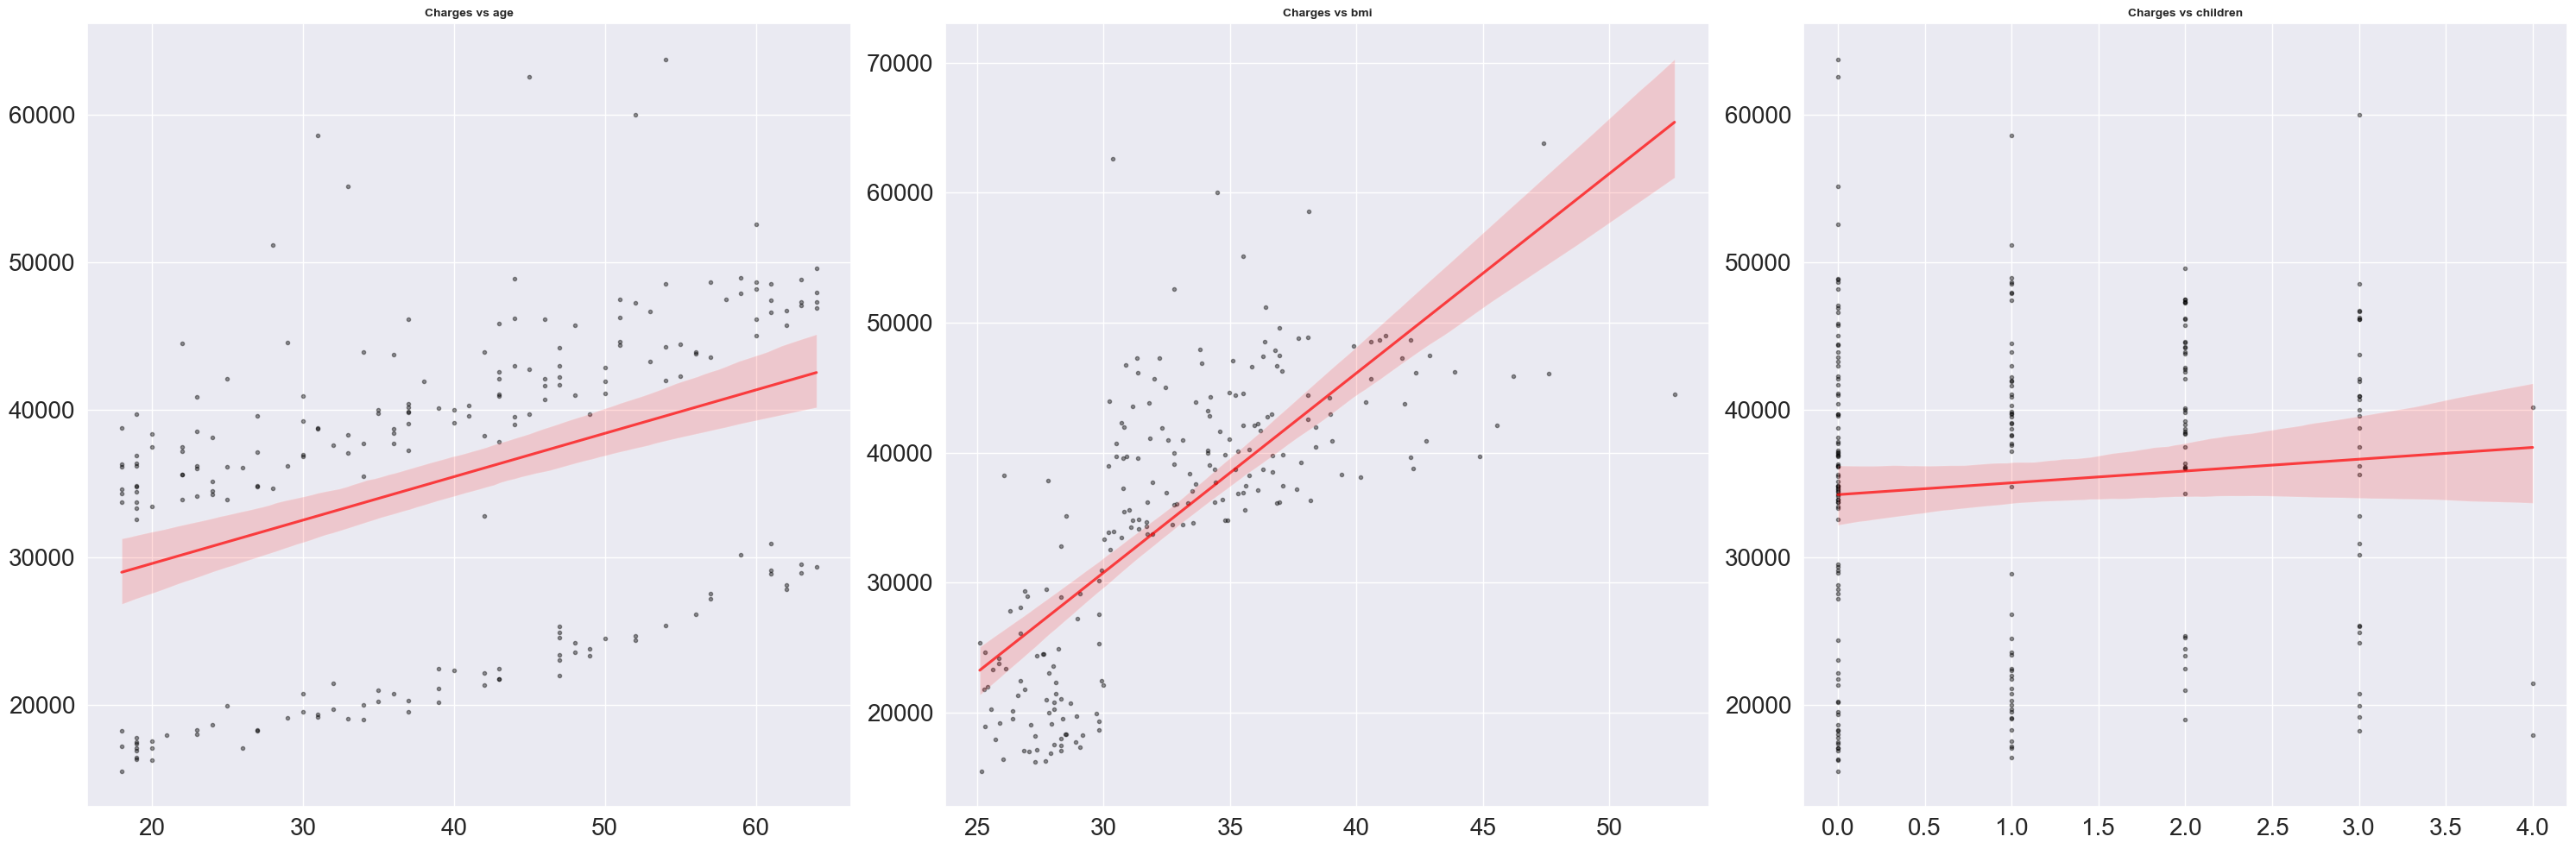

In [141]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
numericas = numericas_fum_no_saludables.drop("charges", axis=1) 

for i, colum in enumerate(numericas):
    sns.regplot(
        x = dffum_no_saludable[colum], 
        y = dffum_no_saludable["charges"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])  
    axes[i].set_title(f"Charges vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")   
fig.tight_layout();

In [150]:
dffum_no_saludable.corr(method = 'spearman')#no stienen distribuciones normales

age       bmi  children   charges
age       1.000000  0.033279  0.119622  0.486586
bmi       0.033279  1.000000  0.066277  0.784544
children  0.119622  0.066277  1.000000  0.141579
charges   0.486586  0.784544  0.141579  1.000000

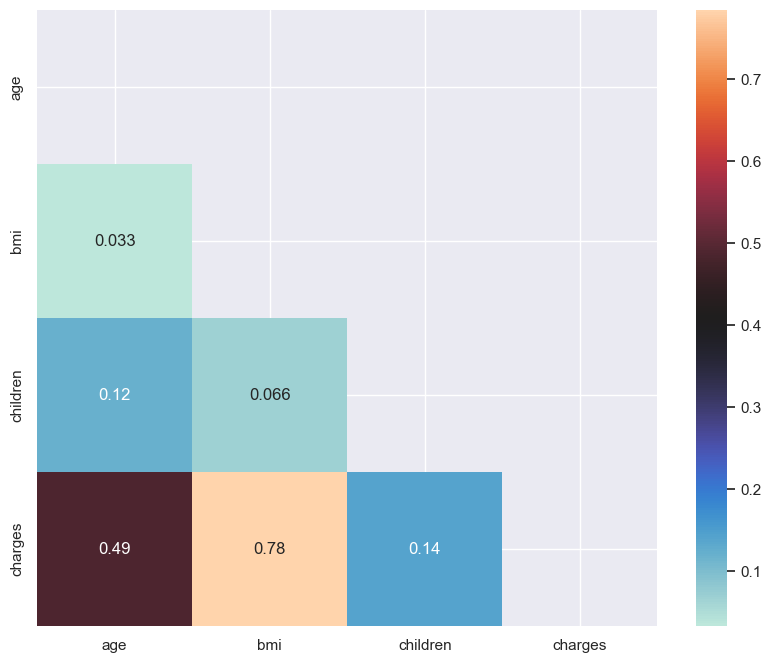

In [152]:
mask = np.triu(np.ones_like(dffum_no_saludable.corr(method = 'spearman'), dtype = np.bool))
sns.heatmap(dffum_no_saludable.corr(method = 'spearman'), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

In [165]:
display(pg.corr(dffum_no_saludable['bmi'], dffum_no_saludable['charges'], method='pearson'))
display(pg.corr(dffum_no_saludable['bmi'], dffum_no_saludable['charges'], method='spearman'))
display(pg.corr(dffum_no_saludable['bmi'], dffum_no_saludable['charges'], method='kendall'))

n         r         CI95%         p-val       BF10  power
pearson  219  0.736148  [0.67, 0.79]  1.195008e-38  2.401e+35    1.0

n         r         CI95%         p-val  power
spearman  219  0.784544  [0.73, 0.83]  6.274185e-47    1.0

n         r         CI95%         p-val  power
kendall  219  0.573352  [0.48, 0.66]  1.805820e-36    1.0

### Vemos que el mayor factor de riesgo es el habito tabaquico, en el caso de BMI saludables, el valor de primas se correlaciona con la edad y en el caso de BMI no saludables, con el valor de la BMI. Y que ha partir de BMI 30 hay un gran sato en el valor de las primas.

In [ ]:
#con primas menores de 23000 son 83, sabemos que de estos 41 son de bmi normal, de bmi normal, quedan 14 de primas mayores.
#Voy a investigarlos

In [44]:
#df1_peso_altas=df_peso_fumador[df_peso_fumador['charges']>=23000]

In [46]:
#df1_peso_altas.describe(include='all')

age     sex        bmi   children smoker     region  \
count   12.000000      12  12.000000  12.000000     12         12   
unique        NaN       2        NaN        NaN      1          3   
top           NaN  female        NaN        NaN    yes  southeast   
freq          NaN       8        NaN        NaN     12          4   
mean    49.500000     NaN  23.172083   1.250000    NaN        NaN   
std     12.602309     NaN   1.839117   1.288057    NaN        NaN   
min     20.000000     NaN  17.765000   0.000000    NaN        NaN   
25%     48.000000     NaN  22.891250   0.000000    NaN        NaN   
50%     52.000000     NaN  23.707500   1.000000    NaN        NaN   
75%     54.500000     NaN  24.177500   2.250000    NaN        NaN   
max     64.000000     NaN  24.795000   3.000000    NaN        NaN   

             charges  
count      12.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    26543.534395  
std      3673.335465  
min     23244.790200  
25%     24072.030175  
50%     25276.081675  
75%     26954.364325  
max     35069.374520

In [47]:
df1_peso_altas.head(12)

age     sex     bmi  children smoker     region      charges
58     53  female  22.880         1    yes  southeast  23244.79020
128    32  female  17.765         2    yes  northwest  32734.18630
262    52    male  24.320         3    yes  northeast  24869.83680
301    53  female  22.610         3    yes  northeast  24873.38490
607    59  female  23.655         0    yes  northwest  25678.77845
664    64  female  22.990         0    yes  southeast  27037.91410
854    49  female  23.845         3    yes  northeast  24106.91255
917    45    male  22.895         0    yes  northeast  35069.37452
966    51    male  24.795         2    yes  northwest  23967.38305
1176   52  female  24.130         1    yes  northwest  23887.66270
1223   20  female  24.420         0    yes  southeast  26125.67477
1265   64    male  23.760         0    yes  southeast  26926.51440

In [128]:
df1.shape #comprobamos el tamaño de nuestro nuevo posible dataset

(274, 7)

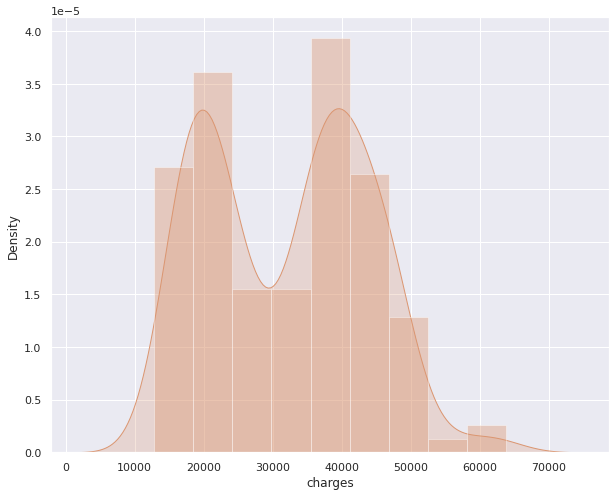

In [129]:
# vamos a ver visualmente como está distribuida la variable respuesta segun fumadores
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df1["charges"], 
    #hist = False, 
    color = "#db9671", 
    kde_kws = {"shade": True, "linewidth": 1});

---

## Personas NO fumadoras

In [130]:
df2 = df[(df['smoker'] == 'no')]
df2.sample(5)

age     sex    bmi  children smoker     region     charges
470    27    male  32.67         0     no  southeast   2497.0383
95     28  female  37.62         1     no  southeast   3766.8838
194    18    male  34.43         0     no  southeast   1137.4697
1061   57    male  27.94         1     no  southeast  11554.2236
6      46  female  33.44         1     no  southeast   8240.5896

In [131]:
df2.shape

(1063, 7)

In [132]:
numericas2 = df2.select_dtypes(include = np.number)

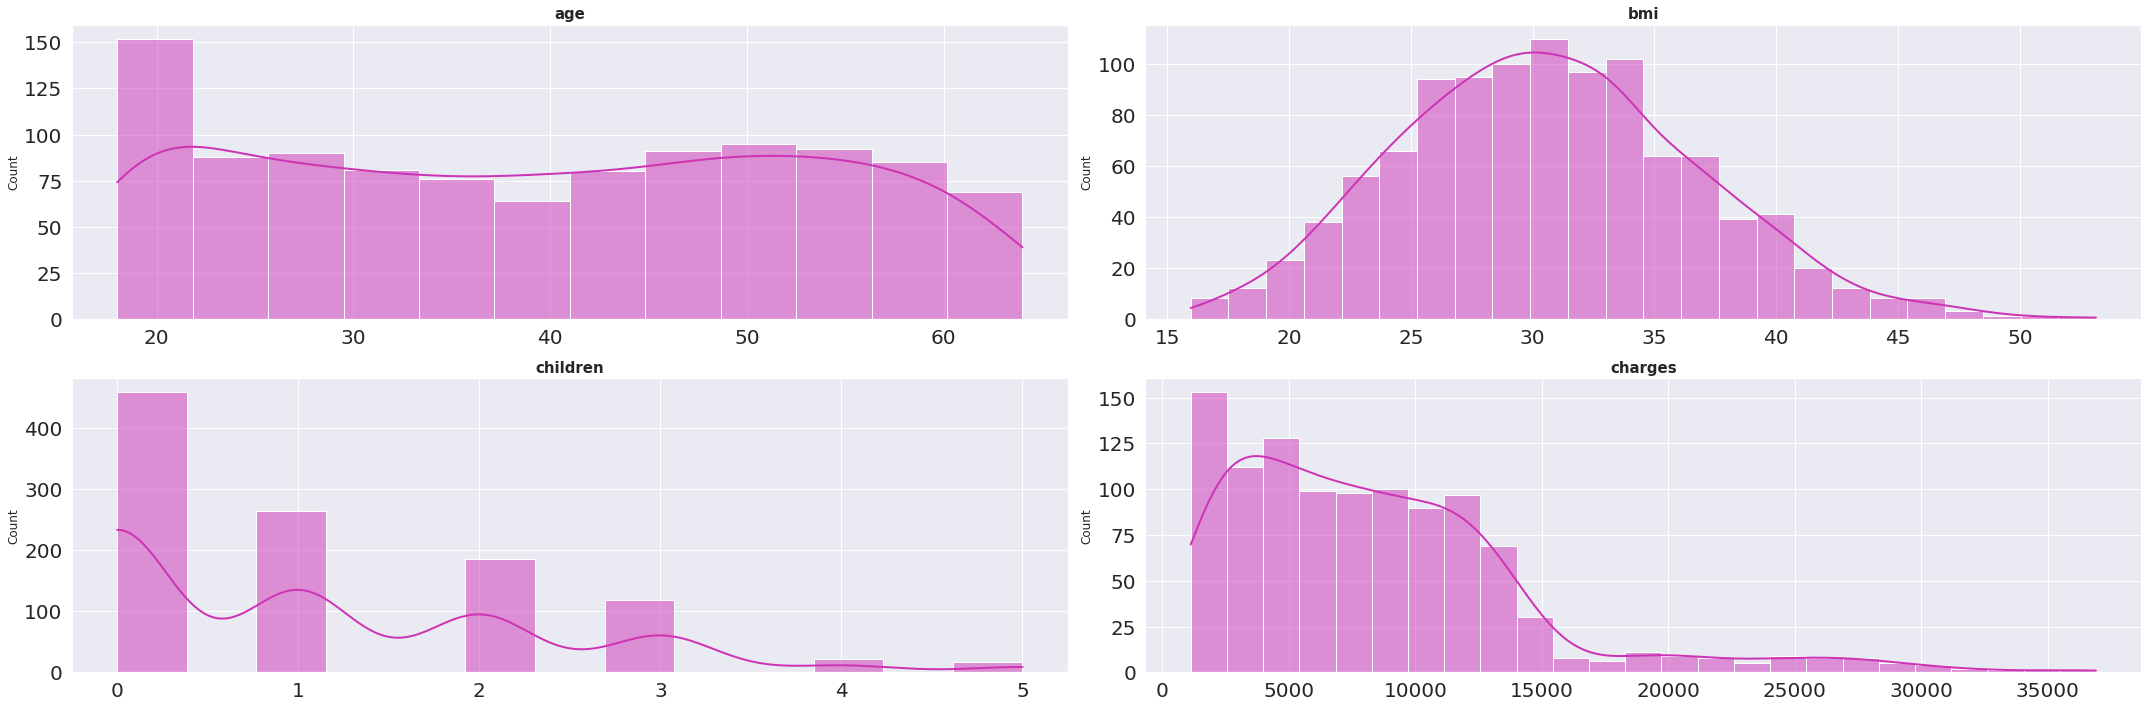

In [133]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas2.columns): 
    sns.histplot(
        data = numericas2[colum],
        kde = True,
        color = "#cd34b5", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

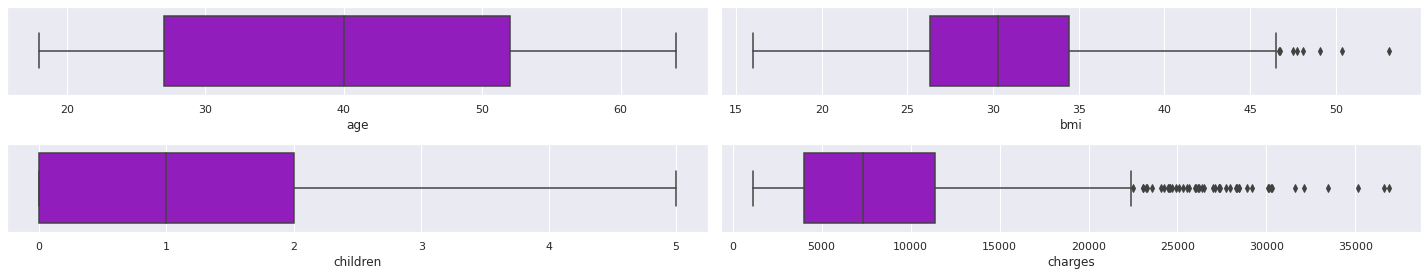

In [134]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas2.columns):
    sns.boxplot(x = numericas2[columna], data = df2, ax=axes[indice], color = "#9d02d7");
plt.tight_layout()
plt.show();

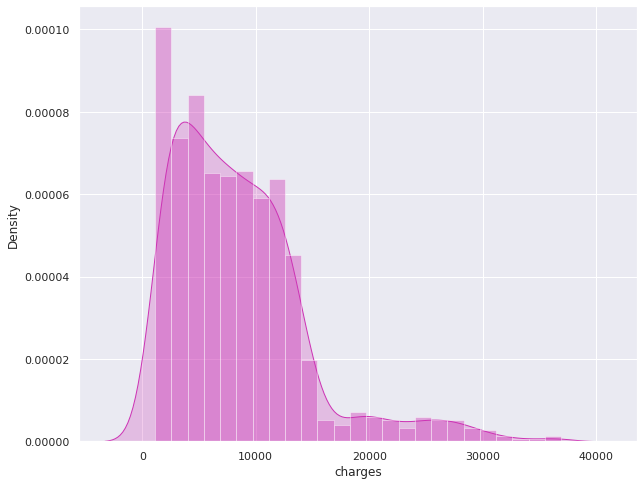

In [135]:
# vamos a ver visualmente como está distribuida la variable respuesta segun no fumadores
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df2["charges"], 
    #hist = False, 
    color = "#cd34b5", 
    kde_kws = {"shade": True, "linewidth": 1});

### Exploarmos según edad

<AxesSubplot:xlabel='age', ylabel='charges'>

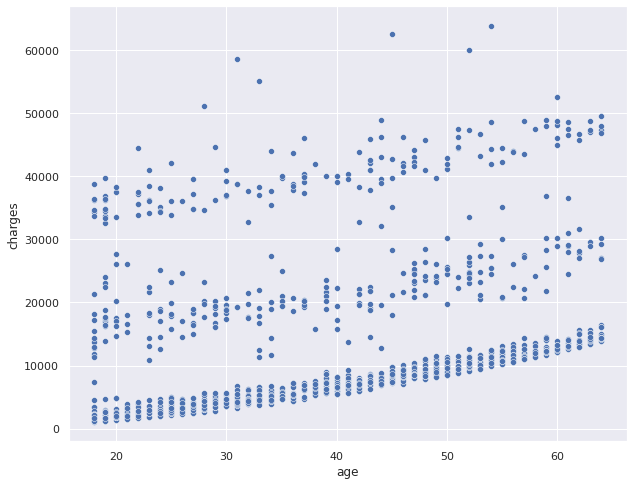

In [136]:
sns.scatterplot(y='charges', x='age', data=df)

Vemos, que hay tres lineas claras de distribución, que podrian identificar las tres 'chepas' de distribución de la variable respuesta, así que vamos a explorar dividiendo entre primas altas y bajas(en vez de las tres categorias que serían altas, medias y bajas que se justificarian con esta distribución segín edades). Ponemos el corte en 20000.

# Primas bajas

In [137]:
df3 = df[(df['charges']<20000)]
df3.head(2)

age     sex    bmi  children smoker     region     charges
0   19  female  27.90         0    yes  southwest  16884.9240
1   18    male  33.77         1     no  southeast   1725.5523

In [138]:
numericas3 = df3.select_dtypes(np.number)
numericas3.head(2)

age    bmi  children     charges
0   19  27.90         0  16884.9240
1   18  33.77         1   1725.5523

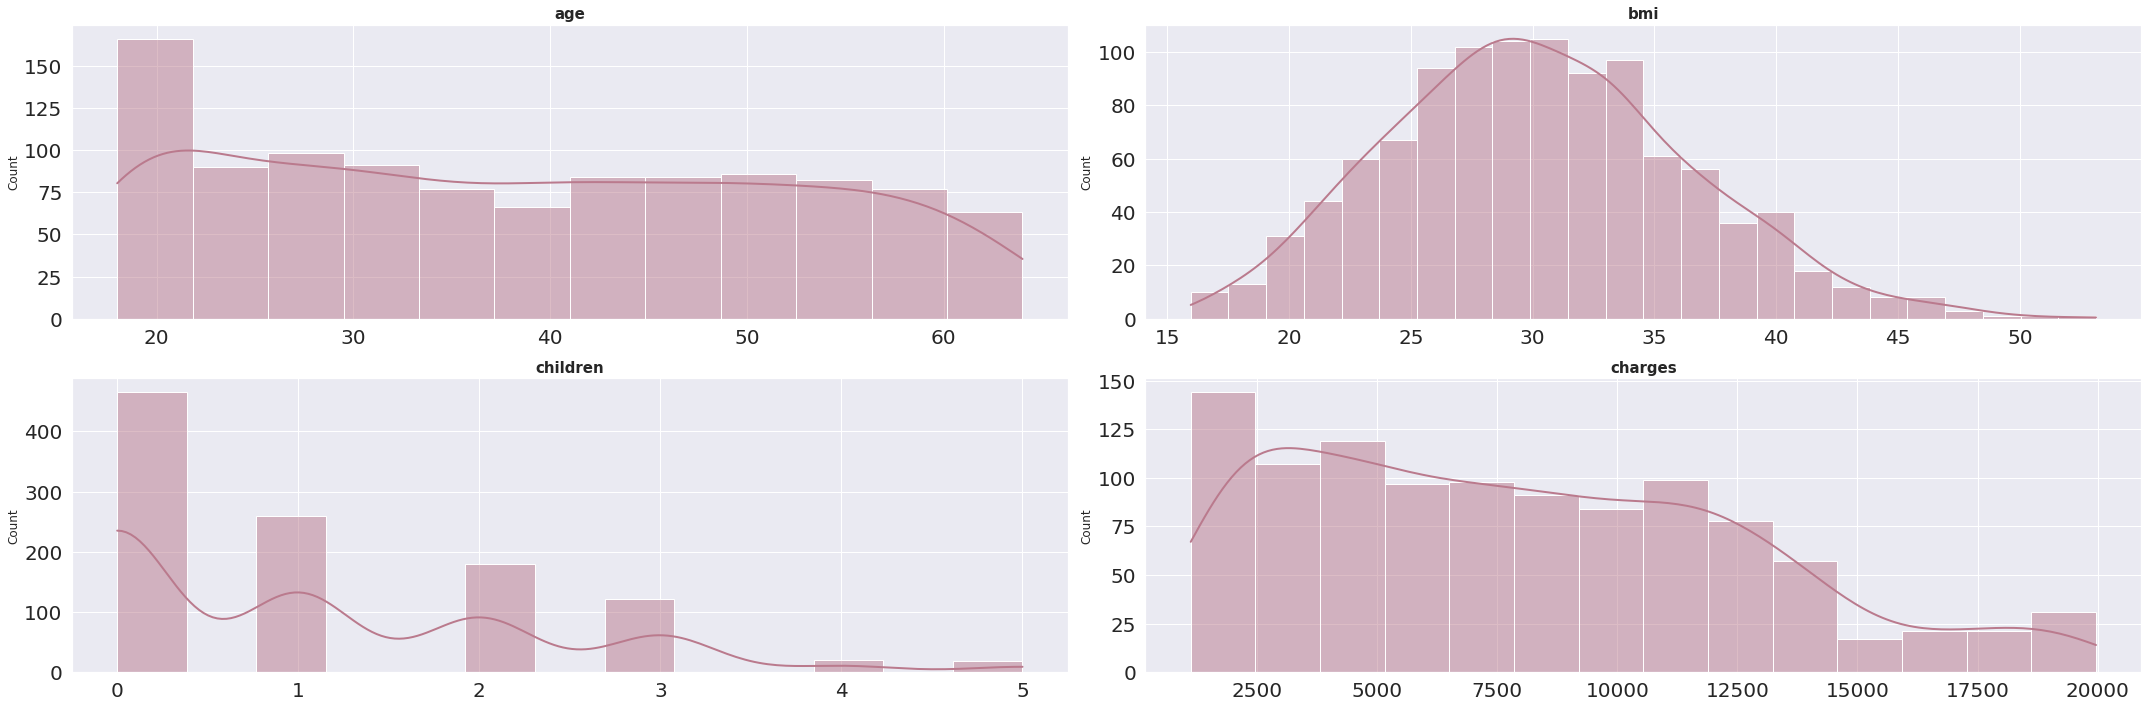

In [139]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas3.columns): 
    sns.histplot(
        data = numericas3[colum],
        kde = True,
        color = "#ba7a8d", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

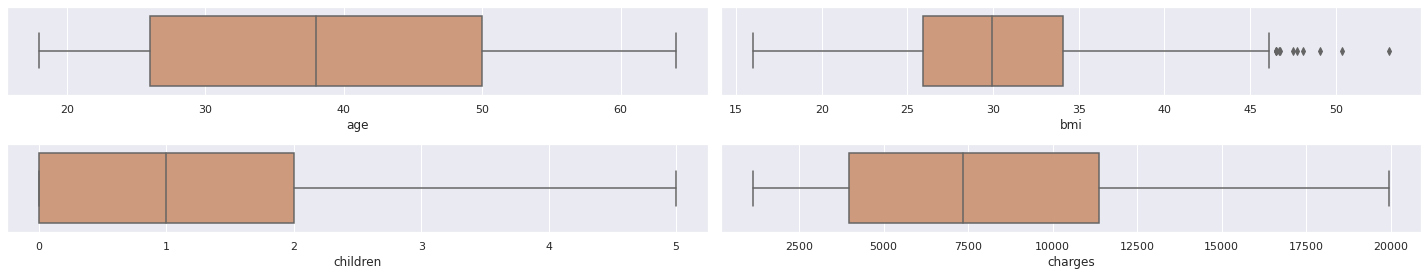

In [140]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas3.columns):
    sns.boxplot(x = numericas3[columna], data = df3, ax=axes[indice], color = "#db9671")
plt.tight_layout()
plt.show();

In [141]:
df3.shape

(1064, 7)

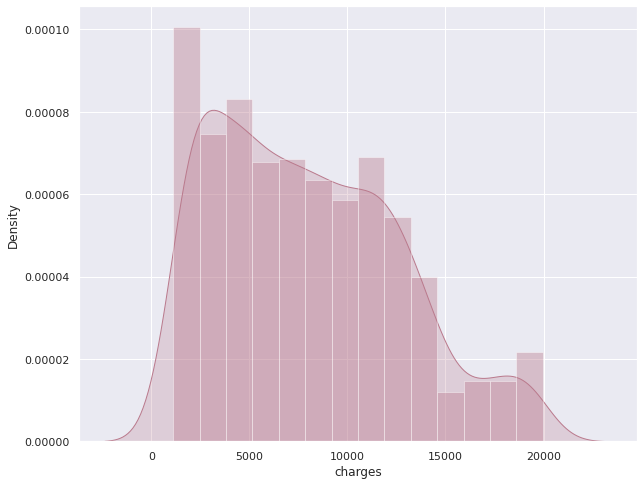

In [142]:
# vamos a ver visualmente como está distribuida la variable respuesta segun cargos bajos
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df3["charges"], 
    #hist = False, 
    color = "#ba7a8d", 
    kde_kws = {"shade": True, "linewidth": 1});

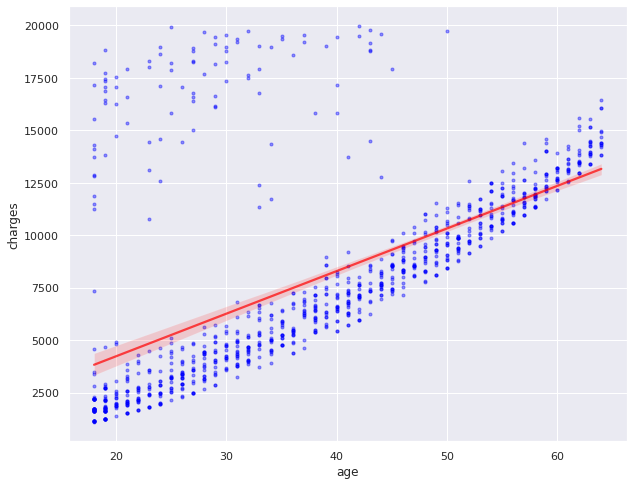

In [143]:
sns.regplot(
        x = df3['age'], 
        y = df3["charges"], 
        color = "blue", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 } );

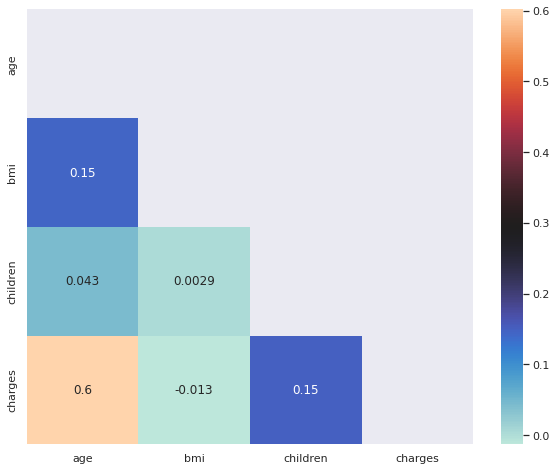

In [144]:
mask = np.triu(np.ones_like(df3.corr(), dtype = np.bool))
sns.heatmap(df3.corr(), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

---

# Primas altas

In [145]:
df4 = df[(df['charges']>=20000)]
df4.head(2)

age     sex     bmi  children smoker     region      charges
3   33    male  22.705         0     no  northwest  21984.47061
9   60  female  25.840         0     no  northwest  28923.13692

In [146]:
numericas4=df4.select_dtypes(np.number)

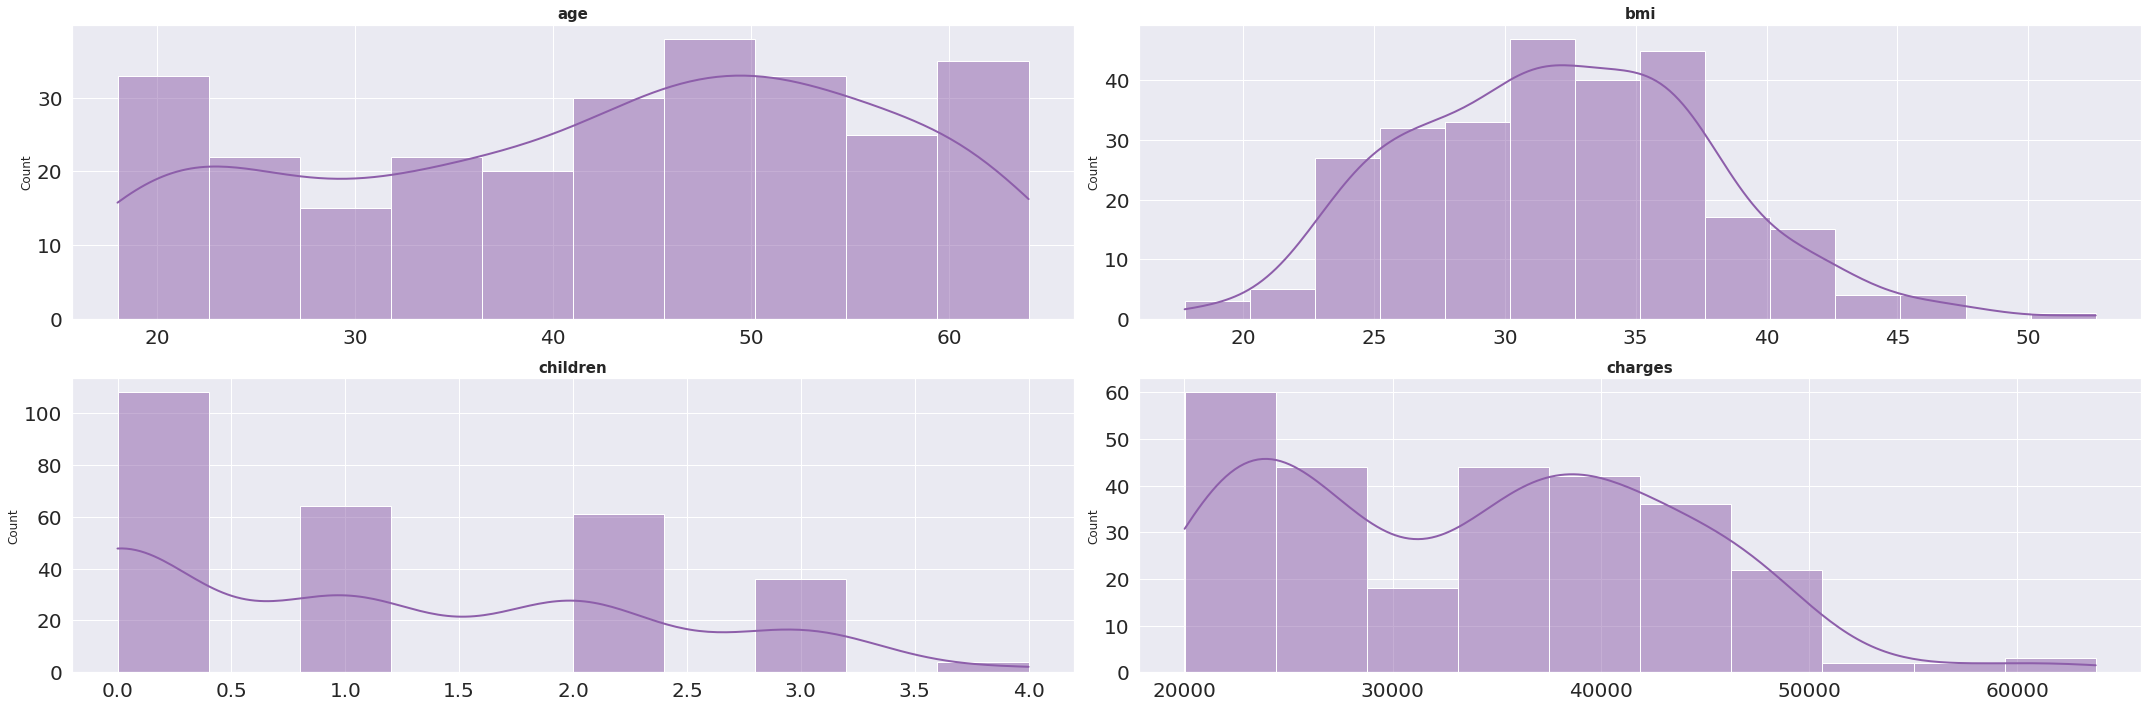

In [147]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas4.columns): 
    sns.histplot(
        data = numericas4[colum],
        kde = True,
        color = '#8d5eaa', 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

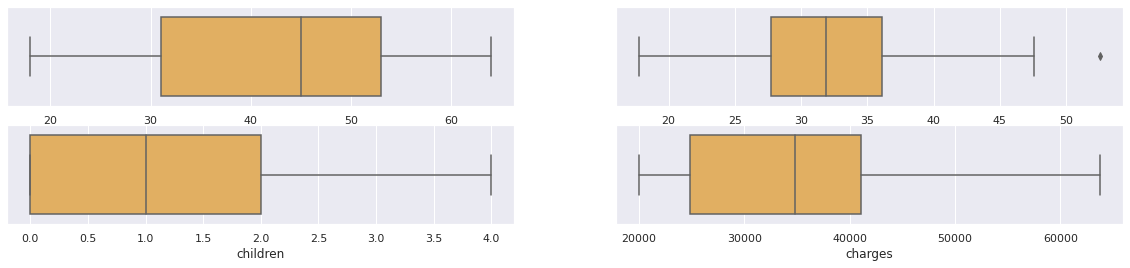

In [148]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas4.columns):
    sns.boxplot(x = numericas4[columna], data = df4, ax=axes[indice], color = '#f6b44d')
plt.show();

In [149]:
df4.shape

(273, 7)

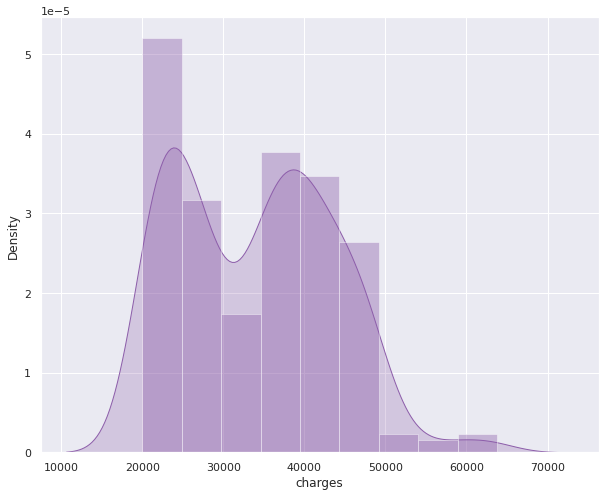

In [150]:
# vamos a ver visualmente como está distribuida la variable respuesta segun cargos altos
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df4["charges"], 
    #hist = False, 
    color = '#8d5eaa', 
    kde_kws = {"shade": True, "linewidth": 1});

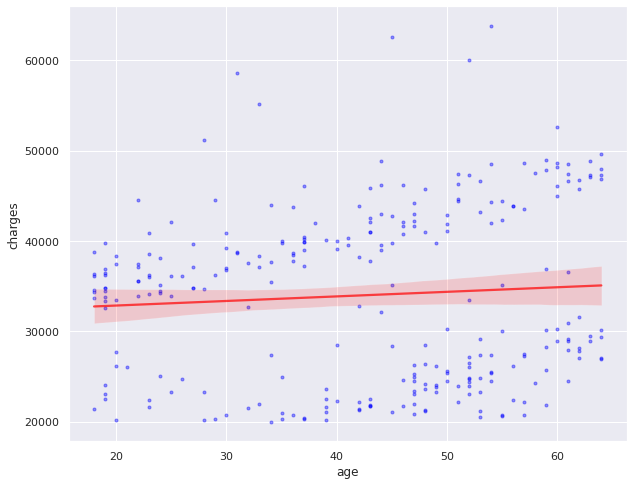

In [151]:
sns.regplot(
        x = df4['age'], 
        y = df4["charges"], 
        color = "blue", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 });

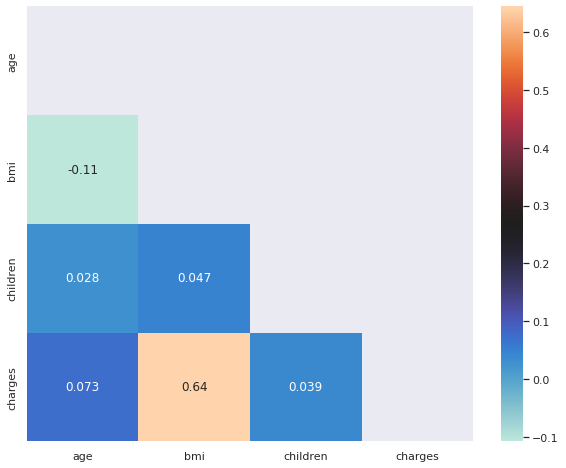

In [152]:
mask = np.triu(np.ones_like(df4.corr(), dtype = np.bool))
sns.heatmap(df4.corr(), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

## Vemos que en las primas bajas existe relación con la edad, pero, que en primas altas, no, asi que vamos a estudiar que otras variables pueden estar afectando a las primas altas.

Primas altas para fumadores

In [54]:
plt.figure(figsize = (10,5)) 
sns.histplot(data =df4, x = "charges", hue = "smoker") 
plt.ylim(0,200)
plt.xlim(0,60000)
plt.xticks(rotation = 45);

NameError: name 'df4' is not defined

<Figure size 1000x500 with 0 Axes>

Primas bajas para fumadores

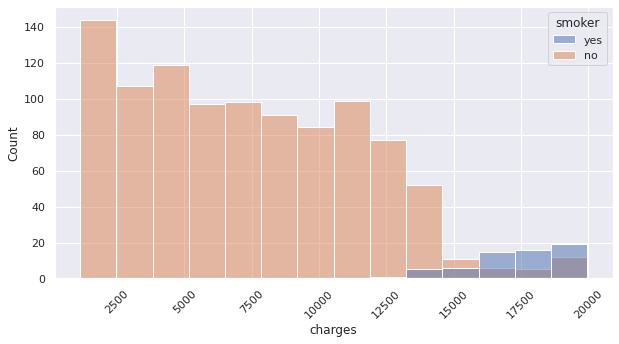

In [154]:
plt.figure(figsize = (10,5)) 
sns.histplot(data =df3, x = "charges", hue = "smoker") 
plt.ylim(0,200)
plt.xlim(0,60000)
plt.xticks(rotation = 45);

fumadores para el df general

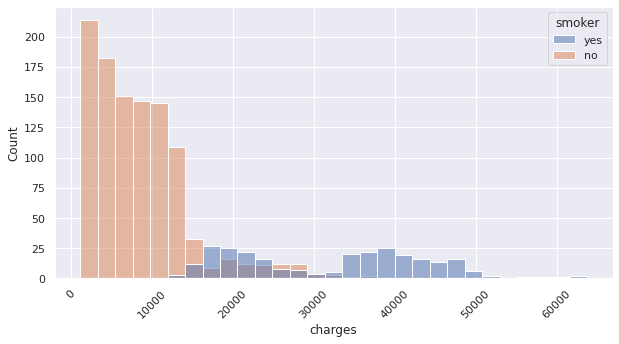

In [155]:
plt.figure(figsize = (10,5))  # establecemos el tamaño de la gráfica
sns.histplot(data =df, x = "charges", hue = "smoker") 
plt.xticks(rotation = 45);

In [156]:
df3['smoker'].value_counts()

no     1002
yes      62
Name: smoker, dtype: int64

In [157]:
df4['smoker'].value_counts()

yes    212
no      61
Name: smoker, dtype: int64

In [158]:
df3.shape

(1064, 7)

In [159]:
df4.shape

(273, 7)

In [160]:
w=df3['charges'].mean()

In [161]:
df3.shape[0]*w

8476250.48524899

In [162]:
c=df4['charges'].mean()

In [163]:
df4.shape[0]*c

9277934.94241

---

        Partimos de datos poblacionales con problemas de sobrepeso, incluye menos de 25% de los registros con BMI 
        inferiores a 25.Analizando las pólizas correspondientes a BMI saludables, están incluidos en más del 75% de los casos dentro de primas bajas, sean fumadores, o no. Tenemos dos dataframes resultantes de las dos jorobas de 'charges',la de primas bajas mas relacionada con edades, y la de altas, relacionada con hábitos tabaquicos.

>Segun la muestra, económicamente, son similares para la compañia pero con n muy dispares,
 >optamos por quedarnos con las primas bajas, con una n más alta, 
 >y relacionar dos variables numéricas, edad y prima. Ya que el tiempo de pair, es limitado.


> Gráficamente vemos claramente que las primas altas, se relacionan más con el hábito tabaquico si y edades altas, y las primas bajas, a penas tienen representacion de ese grupo.

> Calculando media de primas y numero de registros, el impacto economico de ambos grupos en los que hemos dividido la muestra es bastante similar.

# Gestión de Outliers de nuestro dataset 'Primas bajas'

In [164]:
numericas3=df3.select_dtypes(np.number)
numericas3

age    bmi  children     charges
0      19  27.90         0  16884.9240
1      18  33.77         1   1725.5523
2      28  33.00         3   4449.4620
4      32  28.88         0   3866.8552
5      31  25.74         0   3756.6216
...   ...    ...       ...         ...
1332   52  44.70         3  11411.6850
1333   50  30.97         3  10600.5483
1334   18  31.92         0   2205.9808
1335   18  36.85         0   1629.8335
1336   21  25.80         0   2007.9450

[1064 rows x 4 columns]

In [165]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1064 non-null   int64  
 1   sex       1064 non-null   object 
 2   bmi       1064 non-null   float64
 3   children  1064 non-null   int64  
 4   smoker    1064 non-null   object 
 5   region    1064 non-null   object 
 6   charges   1064 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.5+ KB


In [166]:
numericas3=df3.drop('charges', axis=1)
numericas3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1064 non-null   int64  
 1   sex       1064 non-null   object 
 2   bmi       1064 non-null   float64
 3   children  1064 non-null   int64  
 4   smoker    1064 non-null   object 
 5   region    1064 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 58.2+ KB


In [167]:
numericas3_bis=numericas3.select_dtypes(np.number)
numericas3_bis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 0 to 1336
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1064 non-null   int64  
 1   bmi       1064 non-null   float64
 2   children  1064 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 33.2 KB


In [168]:
def detectar_outliers(lista_columnas, dataframe): 
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        # calculamos los límites
        outlier_step = 1.5 * IQR
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    
    return dicc_indices 

In [169]:
lista_columnas3 = list(numericas3_bis.columns)
ind3 = detectar_outliers(lista_columnas3, numericas3)

In [170]:
ind3.keys()

dict_keys(['bmi'])

In [171]:
# Iteramos por el diccionario que hemos creado con los índices de los outliers
for k, v in ind3.items():
    # Sacamos la mediana de cada columna numérica
    mediana = df3[k].median()
    # iteramos por cada fila de la columna en la que hay outliers y convertimos ese valor en la mediana
    for i in v:
        df3.loc[i,k] = mediana

In [172]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1064 non-null   int64  
 1   sex       1064 non-null   object 
 2   bmi       1064 non-null   float64
 3   children  1064 non-null   int64  
 4   smoker    1064 non-null   object 
 5   region    1064 non-null   object 
 6   charges   1064 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 98.8+ KB


# Guardamos los nuevos archivos con las divisiones

In [173]:
df1.to_csv("../data/01-dataframe_fumadores.csv" )

In [174]:
df2.to_csv("../data/02-dataframe_no_fumadores.csv" )

In [175]:
df3.to_csv("../data/03-primas_bajas.csv" )

In [176]:
df4.to_csv("../data/04-primas_altas.csv" )